In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import random
import math
import pandas as pd

# Path to your Excel file
file_path = './UPDATED_NM student infractions 2010-2022.xlsx'

# Read the Excel file
df = pd.read_excel(file_path)

# Display the DataFrame
print(df)

                   District Name  District Code  \
0       ABQ SCHOOL OF EXCELLENCE            516   
1       ABQ SCHOOL OF EXCELLENCE            516   
2       ABQ SCHOOL OF EXCELLENCE            516   
3       ABQ SCHOOL OF EXCELLENCE            516   
4       ABQ SCHOOL OF EXCELLENCE            516   
...                          ...            ...   
285912                      ZUNI             89   
285913                      ZUNI             89   
285914                      ZUNI             89   
285915                      ZUNI             89   
285916                      ZUNI             89   

       Location Organization Type Code School Year Student Grade Level  \
0                              Charter  2014-06-30                   8   
1                              Charter  2014-06-30                   8   
2                              Charter  2014-06-30                   8   
3                              Charter  2014-06-30                   8   
4                

In [2]:
column_names = df.columns
print(column_names)
print(len(df))
group_lengths_list = df.groupby('District Name').size().tolist()
print(group_lengths_list)

Index(['District Name', 'District Code', 'Location Organization Type Code',
       'School Year', 'Student Grade Level', 'Infraction Event ID',
       'Discipline Infraction Date', 'Discipline Infraction Code',
       'Discipline Infraction', 'Drug Related', 'Alcohol Related',
       'Gang Related', 'Hate Crime', 'Serious Injury', 'Criminal Charge Code',
       'Repeat Offender', 'Discipline Response Code', 'Discipline Response',
       'Discipline Response Duration', 'Admin First Name', 'Admin Last Name',
       'Admin License Number', 'Student Gender Code',
       'Student Race Ethnicity Derived', 'Student Hispanic Indicator',
       'Special Ed Status Code', 'Gifted Participation Code', 'Immigrant',
       'Food Program Participation Code', 'Section 504 Status', 'R3', 'W1',
       'W2', 'W4', 'W5', 'WD', 'WDO', 'WG', 'WC'],
      dtype='object')
285917
[289, 9, 240, 48, 3751, 88971, 11, 3, 161, 60, 5, 133, 8, 10, 472, 4124, 4463, 2793, 1527, 294, 4621, 196, 5114, 177, 27, 183, 273, 

*PRIVACY MECHANISM*
Noising Entire Dataset (but assuming we are noising batches of data per year)
Varying Epsilon value per school, smaller school gets smaller epsilon (how? TODO)

In [3]:
def get_flip_probability(k, epsilon):
    """
    Compute flip probability based on K-ary Randomized Response equation.
    
    Calculates the probability to flip to a value based on the K-ary Randomized Response equation:
    PRflip = 1 - e^epsilon / (e^epsilon + k - 1)
    
    Args:
        k (int): Number of values (alphabets/categories) in the distribution (column).
        epsilon (float): The privacy budget.
    
    Returns:
        float: The probability to flip to a value.
    """
    PRflip = 1 - math.e**epsilon / (math.e**epsilon + k - 1)
    return PRflip

def flip_value(x, X, epsilon):
    """
    Randomly flips the value of 'x' using K-ary randomized response mechanism.
    
    Uses K-ary randomized response mechanism to randomly replace the value of 'x' with another value 'y' selected from 'X'.
    
    Args:
        x: The input value to potentially flip.
        X: A list of other possible values to choose from.
        epsilon: The privacy budget.
    
    Returns:
        y: The flipped or unchanged value of 'x'.
    """
    # Generate a random number between 0 and 1
    random_number = random.random()
    # Generate probability to flip x
    k = len(X) # number of values (alphabets/categories) in the domain
    flip_probability = get_flip_probability(k, epsilon)
    # Check if we should flip the value
    if random_number <= flip_probability:
        # Flip the value by selecting a random value from known_values other than 'x'
        y = random.choice([value for value in X if value != x])
        return y
    else:
        # Keep the value x
        return x

def noise_column(c_sr, X, epsilon):
    """
    Applies differential privacy to an entire column.
    
    Parameters:
        c_sr (pandas.Series): Pandas Series containing values from the column of interest.
        X (list): Possible values in the column.
        epsilon (float): Privacy budget for differential privacy. Lower values mean more privacy.
    
    Returns:
        list: List of privatized column values.
    """
    # Apply differential privacy to the list of c_sr
    c_private = map(lambda x: flip_value(x, X, epsilon), c_sr.tolist())
    c_private= list(c_private)
    return c_private

def get_epsilon(size, epsilon_config):
    """
    Get epsilon value depending on the number of entries in group/school.

    Parameters:
        size (int): Number of entries.
        epsilon_config (list): List of nested lists containing upper bound, lower bound, and corresponding epsilon value.

    Returns:
        float: Epsilon value.
    """
    default_epsilon = 1  # Default epsilon value
    epsilon = default_epsilon

    try:
        for config in epsilon_config:
            lower_bound, upper_bound, value = config
            if lower_bound <= size < upper_bound:
                epsilon = value
                print("Epsilon found: ", epsilon)
                break
            if upper_bound == -1 and size >= lower_bound:
                epsilon = value
                print("Epsilon found: ", epsilon)
                break
    except (TypeError, ValueError, IndexError):
        print("Warning: Epsilon configuration is poorly formatted. Default epsilon value will be used.")
        epsilon = default_epsilon

    return epsilon

def generate_possible_values(df, columns_to_noise):
    """
    Creates a dictionary of column names and lists of their respective values from the entire dataset.
    Only for columns that need to be noised.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing the school data.
        columns_to_noise (list): List of column headers that need to be noised.
    
    Returns:
        dict: Dictionary of column names and lists of their respective values.
    """
    possible_values = {}
    
    try:
        # Iterate over columns
        for column in columns_to_noise:
            # Get unique values for the column
            possible_values[column] = df[column].unique().tolist()
    except KeyError as e:
        print(f"Error: Column '{e}' not found in the DataFrame.")
    
    return possible_values


def noise_dataframe(df, columns_to_noise, epsilon_config):
    """
    Apply noising for entire dataset by noising every school district with adapted epsilon value. Columns are noised independently.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing the school data.
        columns_to_noise (list): List of column headers that need to be noised.
        epsilon_config (list): List of nested lists containing upper bound, lower bound, and corresponding epsilon value.
    
    Returns:
        pandas.DataFrame: DataFrame with noised values.
    """
    df_noised = pd.DataFrame(columns=df.columns)  # Empty placeholder
    
    # Generate possible values per column of interest
    values_per_column = generate_possible_values(df, columns_to_noise)
    
    # Get names of schools/school districts
    school_names = df['District Name'].unique().tolist()
    
    # Noising every school
    for school in school_names:
        print("*~*~*~*~* Running School:", school, "*~*~*~*~*")
        school_df = df[df['District Name'] == school].copy()
        
        # Get adaptive epsilon value
        school_case_numbers = len(school_df)
        curr_epsilon = get_epsilon(school_case_numbers, epsilon_config)
        
        for column in columns_to_noise:
            # Get unique values of column
            X = values_per_column[column]
            
            # Noise column
            noised_column = noise_column(school_df[column], X, curr_epsilon)
            school_df[column] = noised_column
        
        # Append noised school DataFrame to main noised DataFrame
        df_noised = pd.concat([df_noised, school_df], ignore_index=True)
    
    return df_noised

In [4]:
# TEST RUN NOISING
columns_to_noise = ["Discipline Infraction","Student Race Ethnicity Derived","Drug Related","Alcohol Related","Gang Related","Hate Crime","Serious Injury","Criminal Charge Code","Repeat Offender","Immigrant","Gifted Participation Code","Student Grade Level","Student Gender Code"
]
epsilon_config = [[0, 100, 3], [101, 1000, 4], [1001, -1, 5]] # adaptive epsilons for case numbers per school's, set [0, -1, {e_value}] for same epsilon for all 
noised_df = noise_dataframe(df, columns_to_noise, epsilon_config)

*~*~*~*~* Running School: ABQ SCHOOL OF EXCELLENCE *~*~*~*~*
Epsilon found:  4
*~*~*~*~* Running School: ABQ SIGN LANGUAGE ACADEMY *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: ACADEMY OF TRADES AND TECH *~*~*~*~*
Epsilon found:  4
*~*~*~*~* Running School: ACE LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: ALAMOGORDO *~*~*~*~*
Epsilon found:  5
*~*~*~*~* Running School: ALBUQUERQUE *~*~*~*~*
Epsilon found:  5
*~*~*~*~* Running School: ALBUQUERQUE BILINGUAL ACADEMY *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: ALBUQUERQUE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: ALDO LEOPOLD CHARTER *~*~*~*~*
Epsilon found:  4
*~*~*~*~* Running School: ALMA D'ARTE CHARTER *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: ALTURA PREPARATORY SCHOOL *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: AMY BIEHL CHARTER HIGH SCHOOL *~*~*~*~*
Epsilon found:  4
*~*~*~*~* Running School: ANIMAS *~*~*~*~*
Epsilon found:  

*~*~*~*~* Running School: RESERVE *~*~*~*~*
Epsilon found:  4
*~*~*~*~* Running School: RIO RANCHO *~*~*~*~*
Epsilon found:  5
*~*~*~*~* Running School: ROSWELL *~*~*~*~*
Epsilon found:  5
*~*~*~*~* Running School: RUIDOSO *~*~*~*~*
Epsilon found:  5
*~*~*~*~* Running School: SAGE MONTESSORI CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: SAN JON *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: SANDOVAL ACADEMY OF BILINGUAL EDUCATION *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: SANTA FE *~*~*~*~*
Epsilon found:  5
*~*~*~*~* Running School: SANTA ROSA *~*~*~*~*
Epsilon found:  4
*~*~*~*~* Running School: SCHOOL OF DREAMS ACADEMY *~*~*~*~*
Epsilon found:  4
*~*~*~*~* Running School: SILVER CITY *~*~*~*~*
Epsilon found:  4
*~*~*~*~* Running School: SIX DIRECTIONS INDIGENOUS SCHOOL *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: SOCORRO *~*~*~*~*
Epsilon found:  4
*~*~*~*~* Running School: SOLARE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3

======================RAW DF======================
REPEATED COUNTS===============================


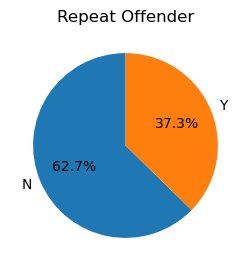

Grade COUNTS==================================
PK      862
KF     4749
1      6359
2      6732
3      7849
4      9322
5     11651
6     35301
7     44601
8     45976
9     46487
10    33491
11    20416
12    12111
OS       10
Name: count, dtype: int64
INFRACTIONS COUNTS==================================
Discipline Infraction
Disorderly Conduct                                                                     86323
Assault/battery with hands/feet/fist                                                   50429
Drug Violation                                                                         36125
Assault/battery simple                                                                 35213
Tobacco Use                                                                            13339
Other Violence - General                                                               11178
Bullying                                                                                7391
Missing Property/Thef

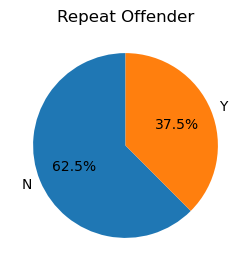

Grade COUNTS==================================
PK     2738
KF     6266
1      7600
2      7990
3      9030
4     10288
5     12429
6     33763
7     42080
8     43167
9     43549
10    31893
11    20364
12    12703
OS     2057
Name: count, dtype: int64
INFRACTIONS COUNTS==================================
Discipline Infraction
Disorderly Conduct                                                                     69643
Assault/battery with hands/feet/fist                                                   41648
Drug Violation                                                                         29715
Assault/battery simple                                                                 29118
Tobacco Use                                                                            11984
Other Violence - General                                                               10241
Bullying                                                                                7498
Missing Property/Thef

In [5]:
import matplotlib.pyplot as plt
def viz_testdf(df):
    # running some queries to quick hand test raw and noised df difference
    print("REPEATED COUNTS===============================")
    repeat_counts = df['Repeat Offender'].value_counts()
    repeat_counts.plot(kind='pie', figsize=(3, 3), autopct='%1.1f%%', startangle=90)
    plt.title('Repeat Offender')
    plt.ylabel('')  # Hide the y-label
    plt.show()
    print("Grade COUNTS==================================")
    # Assuming df['Student Grade Level'] contains the grade levels as shown previously
    grade_counts = df['Student Grade Level'].value_counts()
    # Define the correct order for the grade levels
    grade_order = ['PK', 'KF', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'OS']
    # Convert the grade levels in the index to a Categorical type with the defined order
    grade_counts.index = pd.Categorical(grade_counts.index, categories=grade_order, ordered=True)
    # Sort the Series by its index
    sorted_grade_counts = grade_counts.sort_index()
    print(sorted_grade_counts)
    print("INFRACTIONS COUNTS==================================")
    Discipline_Infraction_counts = df['Discipline Infraction'].value_counts()
    print(Discipline_Infraction_counts)

print("======================RAW DF======================")
viz_testdf(df)
print("======================NOISED DF======================")
viz_testdf(noised_df)

In [6]:
from statistics import mean

def AbsPercentError(orig,noisy):
    return abs(orig - noisy)/(orig+0.0001)

def MeanAbsPercent(df):
    return mean(df.values.flatten())

columns_to_noise = ["Discipline Infraction","Student Race Ethnicity Derived",
                    "Drug Related","Alcohol Related","Gang Related","Hate Crime",
                    "Serious Injury","Criminal Charge Code","Repeat Offender","Immigrant",
                    "Gifted Participation Code","Student Grade Level","Student Gender Code"]
for i in columns_to_noise:
    orig_repeat = df[i].value_counts()
    noisy_repeat = noised_df[i].value_counts()

    some_df = AbsPercentError(orig_repeat,noisy_repeat)
    print(i," Mean Error: ", MeanAbsPercent(some_df))

Discipline Infraction  Mean Error:  22.9347713315592
Student Race Ethnicity Derived  Mean Error:  0.6815370929569072
Drug Related  Mean Error:  0.02327515482216036
Alcohol Related  Mean Error:  0.20790424880560238
Gang Related  Mean Error:  0.3200935380446597
Hate Crime  Mean Error:  3.6074574046650865
Serious Injury  Mean Error:  0.2104095042661638
Criminal Charge Code  Mean Error:  27.503525388242288
Repeat Offender  Mean Error:  0.004410709860986718
Immigrant  Mean Error:  0.33726380316005156
Gifted Participation Code  Mean Error:  0.1532130209076543
Student Grade Level  Mean Error:  13.881343038042493
Student Gender Code  Mean Error:  0.0083185313076391


In [7]:
# Map race names to initials
race_initials = {
    'Caucasian': 'W',
    'Black or African American': 'B',
    'Hispanic': 'H',
    'American Indian/Alaskan Native': 'AI/AN',
    'Multiracial': 'M',
    'Native Hawaiian or Other Pacific Islander': 'NH/OPI',
    'Asian': 'A', }

def NormalizedDistribution(df):
    # Add a new column with race initials
    df['Race Initials'] = df['Student Race Ethnicity Derived'].map(race_initials)

    # Group by Race Initials and Punishment Type, and count the occurrences
    punishment_counts = df.groupby(['Race Initials', 'Discipline Response']).size().unstack(fill_value=0)

    # Normalize the counts by the total number of infractions for each race
    normalized_counts = punishment_counts.div(punishment_counts.sum(axis=1), axis=0)
    return normalized_counts
    
orig_distribution = NormalizedDistribution(df)
noisy_distribution = NormalizedDistribution(noised_df)

some_df = AbsPercentError(orig_distribution,noisy_distribution)
print(" Mean Error: ", MeanAbsPercent(some_df))

 Mean Error:  2.1155416672928675


# Shaohua's Code

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import time

# Different epsilon configurations
epsilon_configs = [
    [[0, 100, 0.2], [101, 1000, 0.4], [1001, -1, 0.5]],
    [[0, 100, 0.5], [101, 1000, 1.0], [1001, -1, 1.5]],
    [[0, 100, 1.5], [101, 1000, 2.0], [1001, -1, 2.5]],
    [[0, 100, 3.0], [101, 1000, 4.0], [1001, -1, 5.0]],
    [[0, 100, 7.0], [101, 1000, 8.0], [1001, -1, 9.0]],
    [[0, 100, 15.0], [101, 1000, 16.0], [1001, -1, 17.0]]
]

# Initialize a list to store noised DataFrames organized by config, each entry will be a list of DataFrames for each run
noised_dfs_by_config = [[] for _ in range(len(epsilon_configs))]

# Apply noise function with different configurations and measure query time
for run in range(10):  # Updated to 10 runs as initially described
    for i, epsilon_config in enumerate(epsilon_configs):
        # Apply noise
        noised_df = noise_dataframe(df, columns_to_noise, epsilon_config)
        noised_dfs_by_config[i].append(noised_df)

*~*~*~*~* Running School: ABQ SCHOOL OF EXCELLENCE *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: ABQ SIGN LANGUAGE ACADEMY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: ACADEMY OF TRADES AND TECH *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: ACE LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: ALAMOGORDO *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: ALBUQUERQUE *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: ALBUQUERQUE BILINGUAL ACADEMY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: ALBUQUERQUE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: ALDO LEOPOLD CHARTER *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: ALMA D'ARTE CHARTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: ALTURA PREPARATORY SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: AMY BIEHL CHARTER HIGH SCHOOL *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: ANIMAS *~

*~*~*~*~* Running School: RATON *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: RED RIVER VALLEY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: RESERVE *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: RIO RANCHO *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: ROSWELL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: RUIDOSO *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: SAGE MONTESSORI CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SAN JON *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SANDOVAL ACADEMY OF BILINGUAL EDUCATION *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SANTA FE *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: SANTA ROSA *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: SCHOOL OF DREAMS ACADEMY *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: SILVER CITY *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: SIX DIRECTIONS INDIGENOUS SCHOOL *~*~

*~*~*~*~* Running School: J PAUL TAYLOR ACADEMY *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: JEMEZ MOUNTAIN *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: JEMEZ VALLEY *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: JUVENILE JUSTICE *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: LA ACADEMIA DOLORES HUERTA *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: LA JICARITA COMMUNITY SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: LA PROMESA EARLY LEARNING *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: LA RESOLANA LEADERSHIP *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: LA TIERRA MONTESSORI SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: LAKE ARTHUR *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: LAS CRUCES *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: LAS MONTANAS CHARTER *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: LAS VEGAS CITY *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Run

*~*~*~*~* Running School: BLOOMFIELD *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: CAPITAN *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: CARLSBAD *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: CARRIZOZO *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: CENTRAL CONS. *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: CENTRAL CONSOLIDATED *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: CESAR CHAVEZ COMMUNITY  CENTER *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: CESAR CHAVEZ COMMUNITY SCHOOL *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: CHAMA *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: CIEN AGUAS INTERNATIONAL  SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: CIMARRON *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: CLAYTON *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: CLOUDCROFT *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: CLOVIS *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~

*~*~*~*~* Running School: SOUTHWEST INTERMEDIATE LEARNING CENTER *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: SOUTHWEST PREPARATORY LEARNING CENTER *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: SOUTHWEST PRIMARY LEARNING CENTER *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: SOUTHWEST SECONDARY LEARNING CENTER *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: SPRINGER *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: STUDENT ATHLETE HEADQUARTERS (SAHQ) *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: SW AERONAUTICS MATHEMATICS AND SCIENCE *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: TAOS *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: TAOS ACADEMY *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: TAOS INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: TATUM *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: TEXICO *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: THE ASK ACADEM

*~*~*~*~* Running School: LOVINGTON *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: MAGDALENA *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: MAXWELL *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: MCCURDY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: MEDIA ARTS CHARTER *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: MEDIA ARTS COLLABORATIVE CHARTER *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: MELROSE *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: MESA VISTA *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: MIDDLE COLLEGE HIGH SCHOOL CHARTER - GALLUP *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: MISSION ACHIEVEMENT AND SUCCESS *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: MONTE DEL SOL CHARTER *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: MORA *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: MORIARTY *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: MORIARTY-EDG

*~*~*~*~* Running School: CUBA *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: DEAP *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: DEMING *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: DES MOINES *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: DEXTER *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: DORA *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: DULCE *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: EAST MTN HIGH SCHOOL *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: ELIDA *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: ESPANOLA *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: ESTANCIA *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: ESTANCIA VALLEY CLASSICAL ACADEMY *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: EUNICE *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: EXPLORE ACADEMY *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: FARMINGTON *~*~*~*~*
Epsilon found:  9.0
*

*~*~*~*~* Running School: TRUTH OR CONS. *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: TUCUMCARI *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: TULAROSA *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: TURQUOISE TRAIL CHARTER SCHOOL *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: VAUGHN *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: VILLAGE ACADEMY *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: WALATOWA CHARTER HIGH *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: WEST LAS VEGAS *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: ZUNI *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: ABQ SCHOOL OF EXCELLENCE *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: ABQ SIGN LANGUAGE ACADEMY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: ACADEMY OF TRADES AND TECH *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: ACE LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: ALAMOGO

*~*~*~*~* Running School: NEW MEXICO CONNECTIONS ACADEMY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: NEW MEXICO INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: NM SCHOOL FOR ARTS *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: NORTH VALLEY ACADEMY CHARTER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: NORTH VALLEY CHARTER *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: PECOS *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: PENASCO *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: POJOAQUE *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: PORTALES *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: QUEMADO *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: QUESTA *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: RALPH J BUNCHE ACADEMY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: RATON *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: RED RIVER VALLEY CHARTER 

*~*~*~*~* Running School: GILBERT L SENA CHARTER HS *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: GRADY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: GRANTS *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: HAGERMAN *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: HATCH *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: HEALTH LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: HEALTH SCIENCES ACADEMY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: HOBBS *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: HONDO *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: HORIZON ACADEMY WEST *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: HOZHO ACADEMY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: INTERNATIONAL SCHOOL AT MESA DEL SOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: J PAUL TAYLOR ACADEMY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: JEMEZ MOUNTAIN *~*~*~*~*
Epsilon

*~*~*~*~* Running School: ALBUQUERQUE BILINGUAL ACADEMY *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: ALBUQUERQUE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: ALDO LEOPOLD CHARTER *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: ALMA D'ARTE CHARTER *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: ALTURA PREPARATORY SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: AMY BIEHL CHARTER HIGH SCHOOL *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: ANIMAS *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: ANTHONY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: ARTESIA *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: AZTEC *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: BELEN *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: BERNALILLO *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: BLOOMFIELD *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: CAPITAN *

*~*~*~*~* Running School: SAGE MONTESSORI CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: SAN JON *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: SANDOVAL ACADEMY OF BILINGUAL EDUCATION *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: SANTA FE *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: SANTA ROSA *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: SCHOOL OF DREAMS ACADEMY *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: SILVER CITY *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: SIX DIRECTIONS INDIGENOUS SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: SOCORRO *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: SOLARE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: SOUTH VALLEY PREP *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: SOUTHWEST INTERMEDIATE LEARNING CENTER *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: SOUTHWEST PREPARATORY LEARNING CENT

*~*~*~*~* Running School: LA TIERRA MONTESSORI SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: LAKE ARTHUR *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: LAS CRUCES *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: LAS MONTANAS CHARTER *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: LAS VEGAS CITY *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: LOGAN *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: LORDSBURG *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: LOS ALAMOS *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: LOS LUNAS *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: LOVING *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: LOVINGTON *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: MAGDALENA *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: MAXWELL *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: MCCURDY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: MEDIA AR

Epsilon found:  4.0
*~*~*~*~* Running School: CLAYTON *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: CLOUDCROFT *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: CLOVIS *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: COBRE CONS. *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: COBRE CONSOLIDATED *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: CORAL COMMUNITY CHARTER *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: COTTONWOOD CLASSICAL PREP *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: CREATIVE ED PREP #1 *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: CUBA *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: DEAP *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: DEMING *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: DES MOINES *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: DEXTER *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: DORA *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: DUL

*~*~*~*~* Running School: TATUM *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: TEXICO *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: THE ASK ACADEMY *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: THE ASK PROGRAM *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: THE GREAT ACADEMY *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: THE LEARNING COMMUNITY *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: THE MASTER PROGRAM *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: TIERRA ADENTRO *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: TIERRA ENCANTADA CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: TRUTH OR CONS. *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: TUCUMCARI *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: TULAROSA *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: TURQUOISE TRAIL CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: VAUGHN *~*~*~*~*
Epsilon foun

*~*~*~*~* Running School: MORIARTY *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: MORIARTY-EDGEWOOD *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: MOSQUERO *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: MOUNTAINAIR *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: NEW AMERICA SCHOOL *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: NEW AMERICA SCHOOL - LAS CRUCES *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: NEW MEXICO CONNECTIONS ACADEMY *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: NEW MEXICO INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: NM SCHOOL FOR ARTS *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: NORTH VALLEY ACADEMY CHARTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: NORTH VALLEY CHARTER *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: PECOS *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: PENASCO *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: P

*~*~*~*~* Running School: FLOYD *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: FT SUMNER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: GADSDEN *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: GALLUP *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: GILBERT L SENA CHARTER HS *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: GRADY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: GRANTS *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: HAGERMAN *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: HATCH *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: HEALTH LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: HEALTH SCIENCES ACADEMY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: HOBBS *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: HONDO *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: HORIZON ACADEMY WEST *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: HOZH

*~*~*~*~* Running School: ALBUQUERQUE BILINGUAL ACADEMY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: ALBUQUERQUE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: ALDO LEOPOLD CHARTER *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: ALMA D'ARTE CHARTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: ALTURA PREPARATORY SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: AMY BIEHL CHARTER HIGH SCHOOL *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: ANIMAS *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: ANTHONY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: ARTESIA *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: AZTEC *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: BELEN *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: BERNALILLO *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: BLOOMFIELD *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: CAPITAN *

*~*~*~*~* Running School: SAGE MONTESSORI CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SAN JON *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SANDOVAL ACADEMY OF BILINGUAL EDUCATION *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SANTA FE *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: SANTA ROSA *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: SCHOOL OF DREAMS ACADEMY *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: SILVER CITY *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: SIX DIRECTIONS INDIGENOUS SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SOCORRO *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: SOLARE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SOUTH VALLEY PREP *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: SOUTHWEST INTERMEDIATE LEARNING CENTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SOUTHWEST PREPARATORY LEARNING CENT

*~*~*~*~* Running School: LA TIERRA MONTESSORI SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: LAKE ARTHUR *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: LAS CRUCES *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: LAS MONTANAS CHARTER *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: LAS VEGAS CITY *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: LOGAN *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: LORDSBURG *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: LOS ALAMOS *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: LOS LUNAS *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: LOVING *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: LOVINGTON *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: MAGDALENA *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: MAXWELL *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: MCCURDY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: MEDIA AR

*~*~*~*~* Running School: CHAMA *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: CIEN AGUAS INTERNATIONAL  SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: CIMARRON *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: CLAYTON *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: CLOUDCROFT *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: CLOVIS *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: COBRE CONS. *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: COBRE CONSOLIDATED *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: CORAL COMMUNITY CHARTER *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: COTTONWOOD CLASSICAL PREP *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: CREATIVE ED PREP #1 *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: CUBA *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: DEAP *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: DEMING *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School

*~*~*~*~* Running School: TAOS *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: TAOS ACADEMY *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: TAOS INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: TATUM *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: TEXICO *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: THE ASK ACADEMY *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: THE ASK PROGRAM *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: THE GREAT ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: THE LEARNING COMMUNITY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: THE MASTER PROGRAM *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: TIERRA ADENTRO *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: TIERRA ENCANTADA CHARTER SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: TRUTH OR CONS. *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: TUCUMCARI *~*~*~*~*
Epsilon found: 

*~*~*~*~* Running School: MIDDLE COLLEGE HIGH SCHOOL CHARTER - GALLUP *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: MISSION ACHIEVEMENT AND SUCCESS *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: MONTE DEL SOL CHARTER *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: MORA *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: MORIARTY *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: MORIARTY-EDGEWOOD *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: MOSQUERO *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: MOUNTAINAIR *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: NEW AMERICA SCHOOL *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: NEW AMERICA SCHOOL - LAS CRUCES *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: NEW MEXICO CONNECTIONS ACADEMY *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: NEW MEXICO INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: NM SCHOOL FOR ARTS *~*~*~*~*
Epsilon 

*~*~*~*~* Running School: ESTANCIA *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: ESTANCIA VALLEY CLASSICAL ACADEMY *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: EUNICE *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: EXPLORE ACADEMY *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: FARMINGTON *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: FLOYD *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: FT SUMNER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: GADSDEN *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: GALLUP *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: GILBERT L SENA CHARTER HS *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: GRADY *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: GRANTS *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: HAGERMAN *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: HATCH *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: HEALTH LEADERSHIP HIGH SCHOO

*~*~*~*~* Running School: ABQ SCHOOL OF EXCELLENCE *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: ABQ SIGN LANGUAGE ACADEMY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: ACADEMY OF TRADES AND TECH *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: ACE LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: ALAMOGORDO *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: ALBUQUERQUE *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: ALBUQUERQUE BILINGUAL ACADEMY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: ALBUQUERQUE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: ALDO LEOPOLD CHARTER *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: ALMA D'ARTE CHARTER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: ALTURA PREPARATORY SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: AMY BIEHL CHARTER HIGH SCHOOL *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running Schoo

Epsilon found:  15.0
*~*~*~*~* Running School: QUESTA *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: RALPH J BUNCHE ACADEMY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: RATON *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: RED RIVER VALLEY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: RESERVE *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: RIO RANCHO *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: ROSWELL *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: RUIDOSO *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: SAGE MONTESSORI CHARTER SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: SAN JON *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: SANDOVAL ACADEMY OF BILINGUAL EDUCATION *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: SANTA FE *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: SANTA ROSA *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: SCHOOL OF 

Epsilon found:  0.2
*~*~*~*~* Running School: JEMEZ MOUNTAIN *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: JEMEZ VALLEY *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: JUVENILE JUSTICE *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: LA ACADEMIA DOLORES HUERTA *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: LA JICARITA COMMUNITY SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: LA PROMESA EARLY LEARNING *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: LA RESOLANA LEADERSHIP *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: LA TIERRA MONTESSORI SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: LAKE ARTHUR *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: LAS CRUCES *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: LAS MONTANAS CHARTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: LAS VEGAS CITY *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: LOGAN *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~*

*~*~*~*~* Running School: BLOOMFIELD *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: CAPITAN *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: CARLSBAD *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: CARRIZOZO *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: CENTRAL CONS. *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: CENTRAL CONSOLIDATED *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: CESAR CHAVEZ COMMUNITY  CENTER *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: CESAR CHAVEZ COMMUNITY SCHOOL *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: CHAMA *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: CIEN AGUAS INTERNATIONAL  SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: CIMARRON *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: CLAYTON *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: CLOUDCROFT *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: CLOVIS *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~

Epsilon found:  0.5
*~*~*~*~* Running School: SOUTHWEST PRIMARY LEARNING CENTER *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: SOUTHWEST SECONDARY LEARNING CENTER *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: SPRINGER *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: STUDENT ATHLETE HEADQUARTERS (SAHQ) *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: SW AERONAUTICS MATHEMATICS AND SCIENCE *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: TAOS *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: TAOS ACADEMY *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: TAOS INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: TATUM *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: TEXICO *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: THE ASK ACADEMY *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: THE ASK PROGRAM *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: THE GREAT ACADEMY *~*~*~*~*
Epsilon fou

*~*~*~*~* Running School: MEDIA ARTS CHARTER *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: MEDIA ARTS COLLABORATIVE CHARTER *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: MELROSE *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: MESA VISTA *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: MIDDLE COLLEGE HIGH SCHOOL CHARTER - GALLUP *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: MISSION ACHIEVEMENT AND SUCCESS *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: MONTE DEL SOL CHARTER *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: MORA *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: MORIARTY *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: MORIARTY-EDGEWOOD *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: MOSQUERO *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: MOUNTAINAIR *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: NEW AMERICA SCHOOL *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: NEW A

*~*~*~*~* Running School: DORA *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: DULCE *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: EAST MTN HIGH SCHOOL *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: ELIDA *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: ESPANOLA *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: ESTANCIA *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: ESTANCIA VALLEY CLASSICAL ACADEMY *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: EUNICE *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: EXPLORE ACADEMY *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: FARMINGTON *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: FLOYD *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: FT SUMNER *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: GADSDEN *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: GALLUP *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: GILBERT L SENA CHARTER HS *~*~*~*~*

*~*~*~*~* Running School: TURQUOISE TRAIL CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: VAUGHN *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: VILLAGE ACADEMY *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: WALATOWA CHARTER HIGH *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: WEST LAS VEGAS *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: ZUNI *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: ABQ SCHOOL OF EXCELLENCE *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: ABQ SIGN LANGUAGE ACADEMY *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: ACADEMY OF TRADES AND TECH *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: ACE LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: ALAMOGORDO *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: ALBUQUERQUE *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: ALBUQUERQUE BILINGUAL ACADEMY *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running 

*~*~*~*~* Running School: PENASCO *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: POJOAQUE *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: PORTALES *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: QUEMADO *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: QUESTA *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: RALPH J BUNCHE ACADEMY *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: RATON *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: RED RIVER VALLEY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: RESERVE *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: RIO RANCHO *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: ROSWELL *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: RUIDOSO *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: SAGE MONTESSORI CHARTER SCHOOL *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: SAN JON *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: SANDOVAL ACADE

*~*~*~*~* Running School: HONDO *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: HORIZON ACADEMY WEST *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: HOZHO ACADEMY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: INTERNATIONAL SCHOOL AT MESA DEL SOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: J PAUL TAYLOR ACADEMY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: JEMEZ MOUNTAIN *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: JEMEZ VALLEY *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: JUVENILE JUSTICE *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: LA ACADEMIA DOLORES HUERTA *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: LA JICARITA COMMUNITY SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: LA PROMESA EARLY LEARNING *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: LA RESOLANA LEADERSHIP *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: LA TIERRA MONTESSORI SCHOOL *~*~*~*~*
Ep

Epsilon found:  0.2
*~*~*~*~* Running School: ARTESIA *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: AZTEC *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: BELEN *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: BERNALILLO *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: BLOOMFIELD *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: CAPITAN *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: CARLSBAD *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: CARRIZOZO *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: CENTRAL CONS. *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: CENTRAL CONSOLIDATED *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: CESAR CHAVEZ COMMUNITY  CENTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: CESAR CHAVEZ COMMUNITY SCHOOL *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: CHAMA *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: CIEN AGUAS INTERNATIONAL  SCHOOL *~*~*~*~*
Epsilon foun

Epsilon found:  0.2
*~*~*~*~* Running School: SOCORRO *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: SOLARE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SOUTH VALLEY PREP *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: SOUTHWEST INTERMEDIATE LEARNING CENTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SOUTHWEST PREPARATORY LEARNING CENTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SOUTHWEST PRIMARY LEARNING CENTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SOUTHWEST SECONDARY LEARNING CENTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SPRINGER *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: STUDENT ATHLETE HEADQUARTERS (SAHQ) *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: SW AERONAUTICS MATHEMATICS AND SCIENCE *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: TAOS *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: TAOS ACADEMY *~*~*~*~*
Epsilon found:  0.4


*~*~*~*~* Running School: LOS ALAMOS *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: LOS LUNAS *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: LOVING *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: LOVINGTON *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: MAGDALENA *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: MAXWELL *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: MCCURDY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: MEDIA ARTS CHARTER *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: MEDIA ARTS COLLABORATIVE CHARTER *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: MELROSE *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: MESA VISTA *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: MIDDLE COLLEGE HIGH SCHOOL CHARTER - GALLUP *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: MISSION ACHIEVEMENT AND SUCCESS *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: MONTE DEL SOL CHARTE

*~*~*~*~* Running School: CUBA *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: DEAP *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: DEMING *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: DES MOINES *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: DEXTER *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: DORA *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: DULCE *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: EAST MTN HIGH SCHOOL *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: ELIDA *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ESPANOLA *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: ESTANCIA *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: ESTANCIA VALLEY CLASSICAL ACADEMY *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: EUNICE *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: EXPLORE ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: FARMINGTON *~*~*~*~*
Epsilon found:  2.5
*

Epsilon found:  1.5
*~*~*~*~* Running School: TIERRA ADENTRO *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: TIERRA ENCANTADA CHARTER SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: TRUTH OR CONS. *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: TUCUMCARI *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: TULAROSA *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: TURQUOISE TRAIL CHARTER SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: VAUGHN *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: VILLAGE ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: WALATOWA CHARTER HIGH *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: WEST LAS VEGAS *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: ZUNI *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: ABQ SCHOOL OF EXCELLENCE *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: ABQ SIGN LANGUAGE ACADEMY *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School

*~*~*~*~* Running School: NM SCHOOL FOR ARTS *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: NORTH VALLEY ACADEMY CHARTER *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: NORTH VALLEY CHARTER *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: PECOS *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: PENASCO *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: POJOAQUE *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: PORTALES *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: QUEMADO *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: QUESTA *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: RALPH J BUNCHE ACADEMY *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: RATON *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: RED RIVER VALLEY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: RESERVE *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: RIO RANCHO *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running Sc

*~*~*~*~* Running School: HATCH *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: HEALTH LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: HEALTH SCIENCES ACADEMY *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: HOBBS *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: HONDO *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: HORIZON ACADEMY WEST *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: HOZHO ACADEMY *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: INTERNATIONAL SCHOOL AT MESA DEL SOL *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: J PAUL TAYLOR ACADEMY *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: JEMEZ MOUNTAIN *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: JEMEZ VALLEY *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: JUVENILE JUSTICE *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: LA ACADEMIA DOLORES HUERTA *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: LA JICAR

*~*~*~*~* Running School: ANTHONY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: ARTESIA *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: AZTEC *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: BELEN *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: BERNALILLO *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: BLOOMFIELD *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: CAPITAN *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: CARLSBAD *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: CARRIZOZO *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: CENTRAL CONS. *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: CENTRAL CONSOLIDATED *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: CESAR CHAVEZ COMMUNITY  CENTER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: CESAR CHAVEZ COMMUNITY SCHOOL *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: CHAMA *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~

*~*~*~*~* Running School: SIX DIRECTIONS INDIGENOUS SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: SOCORRO *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: SOLARE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: SOUTH VALLEY PREP *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: SOUTHWEST INTERMEDIATE LEARNING CENTER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: SOUTHWEST PREPARATORY LEARNING CENTER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: SOUTHWEST PRIMARY LEARNING CENTER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: SOUTHWEST SECONDARY LEARNING CENTER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: SPRINGER *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: STUDENT ATHLETE HEADQUARTERS (SAHQ) *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: SW AERONAUTICS MATHEMATICS AND SCIENCE *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: TAOS *~*~*~*~*
Epsilon f

*~*~*~*~* Running School: LOS ALAMOS *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: LOS LUNAS *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: LOVING *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: LOVINGTON *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: MAGDALENA *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: MAXWELL *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: MCCURDY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: MEDIA ARTS CHARTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: MEDIA ARTS COLLABORATIVE CHARTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: MELROSE *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: MESA VISTA *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: MIDDLE COLLEGE HIGH SCHOOL CHARTER - GALLUP *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: MISSION ACHIEVEMENT AND SUCCESS *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: MONTE DEL SOL CHARTE

Epsilon found:  1.0
*~*~*~*~* Running School: DEAP *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: DEMING *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: DES MOINES *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: DEXTER *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: DORA *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: DULCE *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: EAST MTN HIGH SCHOOL *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: ELIDA *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: ESPANOLA *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ESTANCIA *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: ESTANCIA VALLEY CLASSICAL ACADEMY *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: EUNICE *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: EXPLORE ACADEMY *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: FARMINGTON *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: FLOYD *~*~*~*~*


Epsilon found:  0.5
*~*~*~*~* Running School: TRUTH OR CONS. *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: TUCUMCARI *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: TULAROSA *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: TURQUOISE TRAIL CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: VAUGHN *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: VILLAGE ACADEMY *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: WALATOWA CHARTER HIGH *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: WEST LAS VEGAS *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: ZUNI *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ABQ SCHOOL OF EXCELLENCE *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: ABQ SIGN LANGUAGE ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ACADEMY OF TRADES AND TECH *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: ACE LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running

*~*~*~*~* Running School: NM SCHOOL FOR ARTS *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: NORTH VALLEY ACADEMY CHARTER *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: NORTH VALLEY CHARTER *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: PECOS *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: PENASCO *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: POJOAQUE *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: PORTALES *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: QUEMADO *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: QUESTA *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: RALPH J BUNCHE ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: RATON *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: RED RIVER VALLEY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: RESERVE *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: RIO RANCHO *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running Sc

*~*~*~*~* Running School: HATCH *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: HEALTH LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: HEALTH SCIENCES ACADEMY *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: HOBBS *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: HONDO *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: HORIZON ACADEMY WEST *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: HOZHO ACADEMY *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: INTERNATIONAL SCHOOL AT MESA DEL SOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: J PAUL TAYLOR ACADEMY *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: JEMEZ MOUNTAIN *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: JEMEZ VALLEY *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: JUVENILE JUSTICE *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: LA ACADEMIA DOLORES HUERTA *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: LA JICAR

*~*~*~*~* Running School: ANTHONY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: ARTESIA *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: AZTEC *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: BELEN *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: BERNALILLO *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: BLOOMFIELD *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: CAPITAN *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CARLSBAD *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: CARRIZOZO *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CENTRAL CONS. *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: CENTRAL CONSOLIDATED *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CESAR CHAVEZ COMMUNITY  CENTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: CESAR CHAVEZ COMMUNITY SCHOOL *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CHAMA *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running Scho

Epsilon found:  7.0
*~*~*~*~* Running School: SOCORRO *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: SOLARE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: SOUTH VALLEY PREP *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: SOUTHWEST INTERMEDIATE LEARNING CENTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: SOUTHWEST PREPARATORY LEARNING CENTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: SOUTHWEST PRIMARY LEARNING CENTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: SOUTHWEST SECONDARY LEARNING CENTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: SPRINGER *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: STUDENT ATHLETE HEADQUARTERS (SAHQ) *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: SW AERONAUTICS MATHEMATICS AND SCIENCE *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: TAOS *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: TAOS ACADEMY *~*~*~*~*
Epsilon found:  8.0


*~*~*~*~* Running School: LOS ALAMOS *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: LOS LUNAS *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: LOVING *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: LOVINGTON *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: MAGDALENA *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: MAXWELL *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: MCCURDY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: MEDIA ARTS CHARTER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: MEDIA ARTS COLLABORATIVE CHARTER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: MELROSE *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: MESA VISTA *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: MIDDLE COLLEGE HIGH SCHOOL CHARTER - GALLUP *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: MISSION ACHIEVEMENT AND SUCCESS *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: MONTE D

*~*~*~*~* Running School: COBRE CONS. *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: COBRE CONSOLIDATED *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: CORAL COMMUNITY CHARTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: COTTONWOOD CLASSICAL PREP *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: CREATIVE ED PREP #1 *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: CUBA *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: DEAP *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: DEMING *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: DES MOINES *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: DEXTER *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: DORA *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: DULCE *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: EAST MTN HIGH SCHOOL *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: ELIDA *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: ESPANOLA *~*~*~*

*~*~*~*~* Running School: THE GREAT ACADEMY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: THE LEARNING COMMUNITY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: THE MASTER PROGRAM *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: TIERRA ADENTRO *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: TIERRA ENCANTADA CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: TRUTH OR CONS. *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: TUCUMCARI *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: TULAROSA *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: TURQUOISE TRAIL CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: VAUGHN *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: VILLAGE ACADEMY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: WALATOWA CHARTER HIGH *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: WEST LAS VEGAS *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: ZUNI *~*~*~*~*

*~*~*~*~* Running School: NEW AMERICA SCHOOL *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: NEW AMERICA SCHOOL - LAS CRUCES *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: NEW MEXICO CONNECTIONS ACADEMY *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: NEW MEXICO INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: NM SCHOOL FOR ARTS *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: NORTH VALLEY ACADEMY CHARTER *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: NORTH VALLEY CHARTER *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: PECOS *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: PENASCO *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: POJOAQUE *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: PORTALES *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: QUEMADO *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: QUESTA *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: RALPH J BUNCHE A

*~*~*~*~* Running School: GILBERT L SENA CHARTER HS *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: GRADY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: GRANTS *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: HAGERMAN *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: HATCH *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: HEALTH LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: HEALTH SCIENCES ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: HOBBS *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: HONDO *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: HORIZON ACADEMY WEST *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: HOZHO ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: INTERNATIONAL SCHOOL AT MESA DEL SOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: J PAUL TAYLOR ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: JEMEZ MOUNTAIN *~*~*~*~*
Epsilon

*~*~*~*~* Running School: ALBUQUERQUE BILINGUAL ACADEMY *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: ALBUQUERQUE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: ALDO LEOPOLD CHARTER *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: ALMA D'ARTE CHARTER *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: ALTURA PREPARATORY SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: AMY BIEHL CHARTER HIGH SCHOOL *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: ANIMAS *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: ANTHONY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: ARTESIA *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: AZTEC *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: BELEN *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: BERNALILLO *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: BLOOMFIELD *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: CAPITAN *

Epsilon found:  3.0
*~*~*~*~* Running School: SAN JON *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: SANDOVAL ACADEMY OF BILINGUAL EDUCATION *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: SANTA FE *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: SANTA ROSA *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: SCHOOL OF DREAMS ACADEMY *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: SILVER CITY *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: SIX DIRECTIONS INDIGENOUS SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: SOCORRO *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: SOLARE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: SOUTH VALLEY PREP *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: SOUTHWEST INTERMEDIATE LEARNING CENTER *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: SOUTHWEST PREPARATORY LEARNING CENTER *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: SOUTHWES

Epsilon found:  7.0
*~*~*~*~* Running School: LAKE ARTHUR *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: LAS CRUCES *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: LAS MONTANAS CHARTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: LAS VEGAS CITY *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: LOGAN *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: LORDSBURG *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: LOS ALAMOS *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: LOS LUNAS *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: LOVING *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: LOVINGTON *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: MAGDALENA *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: MAXWELL *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: MCCURDY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: MEDIA ARTS CHARTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running Schoo

Epsilon found:  15.0
*~*~*~*~* Running School: CLOUDCROFT *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: CLOVIS *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: COBRE CONS. *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: COBRE CONSOLIDATED *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: CORAL COMMUNITY CHARTER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: COTTONWOOD CLASSICAL PREP *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: CREATIVE ED PREP #1 *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: CUBA *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: DEAP *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: DEMING *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: DES MOINES *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: DEXTER *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: DORA *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: DULCE *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Runnin

Epsilon found:  17.0
*~*~*~*~* Running School: TAOS ACADEMY *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: TAOS INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: TATUM *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: TEXICO *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: THE ASK ACADEMY *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: THE ASK PROGRAM *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: THE GREAT ACADEMY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: THE LEARNING COMMUNITY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: THE MASTER PROGRAM *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: TIERRA ADENTRO *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: TIERRA ENCANTADA CHARTER SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: TRUTH OR CONS. *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: TUCUMCARI *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running Scho

*~*~*~*~* Running School: MIDDLE COLLEGE HIGH SCHOOL CHARTER - GALLUP *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: MISSION ACHIEVEMENT AND SUCCESS *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: MONTE DEL SOL CHARTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: MORA *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: MORIARTY *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: MORIARTY-EDGEWOOD *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: MOSQUERO *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: MOUNTAINAIR *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: NEW AMERICA SCHOOL *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: NEW AMERICA SCHOOL - LAS CRUCES *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: NEW MEXICO CONNECTIONS ACADEMY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: NEW MEXICO INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: NM SCHOOL FOR ARTS *~*~*~*~*
Epsilon 

*~*~*~*~* Running School: ESTANCIA *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: ESTANCIA VALLEY CLASSICAL ACADEMY *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: EUNICE *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: EXPLORE ACADEMY *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: FARMINGTON *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: FLOYD *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: FT SUMNER *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: GADSDEN *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: GALLUP *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: GILBERT L SENA CHARTER HS *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: GRADY *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: GRANTS *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: HAGERMAN *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: HATCH *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: HEALTH LEADERSHIP HIGH SCHOO

Epsilon found:  0.5
*~*~*~*~* Running School: WEST LAS VEGAS *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: ZUNI *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ABQ SCHOOL OF EXCELLENCE *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: ABQ SIGN LANGUAGE ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ACADEMY OF TRADES AND TECH *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: ACE LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ALAMOGORDO *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: ALBUQUERQUE *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: ALBUQUERQUE BILINGUAL ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ALBUQUERQUE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ALDO LEOPOLD CHARTER *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: ALMA D'ARTE CHARTER *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ALTURA PREPARATORY SCHOOL

Epsilon found:  1.5
*~*~*~*~* Running School: QUESTA *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: RALPH J BUNCHE ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: RATON *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: RED RIVER VALLEY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: RESERVE *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: RIO RANCHO *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: ROSWELL *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: RUIDOSO *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: SAGE MONTESSORI CHARTER SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: SAN JON *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: SANDOVAL ACADEMY OF BILINGUAL EDUCATION *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: SANTA FE *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: SANTA ROSA *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: SCHOOL OF DREAMS ACADEMY

*~*~*~*~* Running School: J PAUL TAYLOR ACADEMY *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: JEMEZ MOUNTAIN *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: JEMEZ VALLEY *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: JUVENILE JUSTICE *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: LA ACADEMIA DOLORES HUERTA *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: LA JICARITA COMMUNITY SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: LA PROMESA EARLY LEARNING *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: LA RESOLANA LEADERSHIP *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: LA TIERRA MONTESSORI SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: LAKE ARTHUR *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: LAS CRUCES *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: LAS MONTANAS CHARTER *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: LAS VEGAS CITY *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Run

Epsilon found:  9.0
*~*~*~*~* Running School: CAPITAN *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CARLSBAD *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: CARRIZOZO *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CENTRAL CONS. *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: CENTRAL CONSOLIDATED *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CESAR CHAVEZ COMMUNITY  CENTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: CESAR CHAVEZ COMMUNITY SCHOOL *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CHAMA *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CIEN AGUAS INTERNATIONAL  SCHOOL *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: CIMARRON *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CLAYTON *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: CLOUDCROFT *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CLOVIS *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: COBRE CONS. *~*~*~*~*
Epsilon

Epsilon found:  8.0
*~*~*~*~* Running School: SOUTHWEST INTERMEDIATE LEARNING CENTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: SOUTHWEST PREPARATORY LEARNING CENTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: SOUTHWEST PRIMARY LEARNING CENTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: SOUTHWEST SECONDARY LEARNING CENTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: SPRINGER *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: STUDENT ATHLETE HEADQUARTERS (SAHQ) *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: SW AERONAUTICS MATHEMATICS AND SCIENCE *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: TAOS *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: TAOS ACADEMY *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: TAOS INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: TATUM *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: TEXICO *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running Sc

*~*~*~*~* Running School: LOS ALAMOS *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: LOS LUNAS *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: LOVING *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: LOVINGTON *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: MAGDALENA *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: MAXWELL *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: MCCURDY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: MEDIA ARTS CHARTER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: MEDIA ARTS COLLABORATIVE CHARTER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: MELROSE *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: MESA VISTA *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: MIDDLE COLLEGE HIGH SCHOOL CHARTER - GALLUP *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: MISSION ACHIEVEMENT AND SUCCESS *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: MONTE D

*~*~*~*~* Running School: COBRE CONS. *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: COBRE CONSOLIDATED *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: CORAL COMMUNITY CHARTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: COTTONWOOD CLASSICAL PREP *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: CREATIVE ED PREP #1 *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: CUBA *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: DEAP *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: DEMING *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: DES MOINES *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: DEXTER *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: DORA *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: DULCE *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: EAST MTN HIGH SCHOOL *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: ELIDA *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: ESPANOLA *~*~*~*

*~*~*~*~* Running School: THE GREAT ACADEMY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: THE LEARNING COMMUNITY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: THE MASTER PROGRAM *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: TIERRA ADENTRO *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: TIERRA ENCANTADA CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: TRUTH OR CONS. *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: TUCUMCARI *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: TULAROSA *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: TURQUOISE TRAIL CHARTER SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: VAUGHN *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: VILLAGE ACADEMY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: WALATOWA CHARTER HIGH *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: WEST LAS VEGAS *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: ZUNI *~*~*~*~*

*~*~*~*~* Running School: NEW AMERICA SCHOOL *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: NEW AMERICA SCHOOL - LAS CRUCES *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: NEW MEXICO CONNECTIONS ACADEMY *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: NEW MEXICO INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: NM SCHOOL FOR ARTS *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: NORTH VALLEY ACADEMY CHARTER *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: NORTH VALLEY CHARTER *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: PECOS *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: PENASCO *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: POJOAQUE *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: PORTALES *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: QUEMADO *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: QUESTA *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: RALPH J BUNCHE A

*~*~*~*~* Running School: GILBERT L SENA CHARTER HS *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: GRADY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: GRANTS *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: HAGERMAN *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: HATCH *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: HEALTH LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: HEALTH SCIENCES ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: HOBBS *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: HONDO *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: HORIZON ACADEMY WEST *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: HOZHO ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: INTERNATIONAL SCHOOL AT MESA DEL SOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: J PAUL TAYLOR ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: JEMEZ MOUNTAIN *~*~*~*~*
Epsilon

*~*~*~*~* Running School: ALBUQUERQUE BILINGUAL ACADEMY *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: ALBUQUERQUE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: ALDO LEOPOLD CHARTER *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: ALMA D'ARTE CHARTER *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: ALTURA PREPARATORY SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: AMY BIEHL CHARTER HIGH SCHOOL *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: ANIMAS *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: ANTHONY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: ARTESIA *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: AZTEC *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: BELEN *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: BERNALILLO *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: BLOOMFIELD *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: CAPITAN *

*~*~*~*~* Running School: SAGE MONTESSORI CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: SAN JON *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: SANDOVAL ACADEMY OF BILINGUAL EDUCATION *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: SANTA FE *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: SANTA ROSA *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: SCHOOL OF DREAMS ACADEMY *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: SILVER CITY *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: SIX DIRECTIONS INDIGENOUS SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: SOCORRO *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: SOLARE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: SOUTH VALLEY PREP *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: SOUTHWEST INTERMEDIATE LEARNING CENTER *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: SOUTHWEST PREPARATORY LEARNING CENT

Epsilon found:  7.0
*~*~*~*~* Running School: LAKE ARTHUR *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: LAS CRUCES *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: LAS MONTANAS CHARTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: LAS VEGAS CITY *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: LOGAN *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: LORDSBURG *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: LOS ALAMOS *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: LOS LUNAS *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: LOVING *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: LOVINGTON *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: MAGDALENA *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: MAXWELL *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: MCCURDY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: MEDIA ARTS CHARTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running Schoo

*~*~*~*~* Running School: CLAYTON *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: CLOUDCROFT *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: CLOVIS *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: COBRE CONS. *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: COBRE CONSOLIDATED *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: CORAL COMMUNITY CHARTER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: COTTONWOOD CLASSICAL PREP *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: CREATIVE ED PREP #1 *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: CUBA *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: DEAP *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: DEMING *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: DES MOINES *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: DEXTER *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: DORA *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: DULCE *~*

*~*~*~*~* Running School: TAOS INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: TATUM *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: TEXICO *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: THE ASK ACADEMY *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: THE ASK PROGRAM *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: THE GREAT ACADEMY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: THE LEARNING COMMUNITY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: THE MASTER PROGRAM *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: TIERRA ADENTRO *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: TIERRA ENCANTADA CHARTER SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: TRUTH OR CONS. *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: TUCUMCARI *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: TULAROSA *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: TURQUOISE TRAIL CHART

*~*~*~*~* Running School: MORIARTY *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: MORIARTY-EDGEWOOD *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: MOSQUERO *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: MOUNTAINAIR *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: NEW AMERICA SCHOOL *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: NEW AMERICA SCHOOL - LAS CRUCES *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: NEW MEXICO CONNECTIONS ACADEMY *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: NEW MEXICO INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: NM SCHOOL FOR ARTS *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: NORTH VALLEY ACADEMY CHARTER *~*~*~*~*
Epsilon found:  0.2
*~*~*~*~* Running School: NORTH VALLEY CHARTER *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: PECOS *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: PENASCO *~*~*~*~*
Epsilon found:  0.4
*~*~*~*~* Running School: P

*~*~*~*~* Running School: FLOYD *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: FT SUMNER *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: GADSDEN *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: GALLUP *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: GILBERT L SENA CHARTER HS *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: GRADY *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: GRANTS *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: HAGERMAN *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: HATCH *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: HEALTH LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: HEALTH SCIENCES ACADEMY *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: HOBBS *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: HONDO *~*~*~*~*
Epsilon found:  0.5
*~*~*~*~* Running School: HORIZON ACADEMY WEST *~*~*~*~*
Epsilon found:  1.0
*~*~*~*~* Running School: HOZHO ACADEMY *~*~

Epsilon found:  2.0
*~*~*~*~* Running School: ACE LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ALAMOGORDO *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: ALBUQUERQUE *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: ALBUQUERQUE BILINGUAL ACADEMY *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ALBUQUERQUE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ALDO LEOPOLD CHARTER *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: ALMA D'ARTE CHARTER *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ALTURA PREPARATORY SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: AMY BIEHL CHARTER HIGH SCHOOL *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: ANIMAS *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ANTHONY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: ARTESIA *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: AZTEC *~*~*~*~*
Epsilon found

*~*~*~*~* Running School: RED RIVER VALLEY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: RESERVE *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: RIO RANCHO *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: ROSWELL *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: RUIDOSO *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: SAGE MONTESSORI CHARTER SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: SAN JON *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: SANDOVAL ACADEMY OF BILINGUAL EDUCATION *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: SANTA FE *~*~*~*~*
Epsilon found:  2.5
*~*~*~*~* Running School: SANTA ROSA *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: SCHOOL OF DREAMS ACADEMY *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: SILVER CITY *~*~*~*~*
Epsilon found:  2.0
*~*~*~*~* Running School: SIX DIRECTIONS INDIGENOUS SCHOOL *~*~*~*~*
Epsilon found:  1.5
*~*~*~*~* Running School: SOCORRO *~

*~*~*~*~* Running School: LA ACADEMIA DOLORES HUERTA *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: LA JICARITA COMMUNITY SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: LA PROMESA EARLY LEARNING *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: LA RESOLANA LEADERSHIP *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: LA TIERRA MONTESSORI SCHOOL *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: LAKE ARTHUR *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: LAS CRUCES *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: LAS MONTANAS CHARTER *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: LAS VEGAS CITY *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: LOGAN *~*~*~*~*
Epsilon found:  3.0
*~*~*~*~* Running School: LORDSBURG *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: LOS ALAMOS *~*~*~*~*
Epsilon found:  4.0
*~*~*~*~* Running School: LOS LUNAS *~*~*~*~*
Epsilon found:  5.0
*~*~*~*~* Running School: LOVING *~*~*~*~*


Epsilon found:  8.0
*~*~*~*~* Running School: CESAR CHAVEZ COMMUNITY  CENTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: CESAR CHAVEZ COMMUNITY SCHOOL *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CHAMA *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CIEN AGUAS INTERNATIONAL  SCHOOL *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: CIMARRON *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CLAYTON *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: CLOUDCROFT *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CLOVIS *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: COBRE CONS. *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: COBRE CONSOLIDATED *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: CORAL COMMUNITY CHARTER *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: COTTONWOOD CLASSICAL PREP *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: CREATIVE ED PREP #1 *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Runnin

Epsilon found:  7.0
*~*~*~*~* Running School: SW AERONAUTICS MATHEMATICS AND SCIENCE *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: TAOS *~*~*~*~*
Epsilon found:  9.0
*~*~*~*~* Running School: TAOS ACADEMY *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: TAOS INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: TATUM *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: TEXICO *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: THE ASK ACADEMY *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: THE ASK PROGRAM *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: THE GREAT ACADEMY *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: THE LEARNING COMMUNITY *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: THE MASTER PROGRAM *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running School: TIERRA ADENTRO *~*~*~*~*
Epsilon found:  8.0
*~*~*~*~* Running School: TIERRA ENCANTADA CHARTER SCHOOL *~*~*~*~*
Epsilon found:  7.0
*~*~*~*~* Running

*~*~*~*~* Running School: MIDDLE COLLEGE HIGH SCHOOL CHARTER - GALLUP *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: MISSION ACHIEVEMENT AND SUCCESS *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: MONTE DEL SOL CHARTER *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: MORA *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: MORIARTY *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: MORIARTY-EDGEWOOD *~*~*~*~*
Epsilon found:  17.0
*~*~*~*~* Running School: MOSQUERO *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: MOUNTAINAIR *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: NEW AMERICA SCHOOL *~*~*~*~*
Epsilon found:  16.0
*~*~*~*~* Running School: NEW AMERICA SCHOOL - LAS CRUCES *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: NEW MEXICO CONNECTIONS ACADEMY *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: NEW MEXICO INTERNATIONAL SCHOOL *~*~*~*~*
Epsilon found:  15.0
*~*~*~*~* Running School: NM SCHOOL FOR ARTS *~*~*~

Query1.Repeat Offender

In [9]:
import time
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a list to store query times for each config, for each of 10 runs
query_times = [[0] * 10 for _ in range(len(epsilon_configs))]
# Initialize a list to store mean errors for each config, for each of 10 runs
mean_errors = [[0] * 10 for _ in range(len(epsilon_configs))]

# After noising, perform queries
for config_index, dfs in enumerate(noised_dfs_by_config):
    for run_index, noised_df in enumerate(dfs):
        start_time = time.time()
        repeat_counts = noised_df['Repeat Offender'].value_counts()
        query_times[config_index][run_index] = time.time() - start_time
        
        orig_distribution = NormalizedDistribution(df)
        noisy_distribution = NormalizedDistribution(noised_df)
        error_df = AbsPercentError(orig_distribution, noisy_distribution)
        mean_error = MeanAbsPercent(error_df)
        mean_errors[config_index][run_index] = mean_error

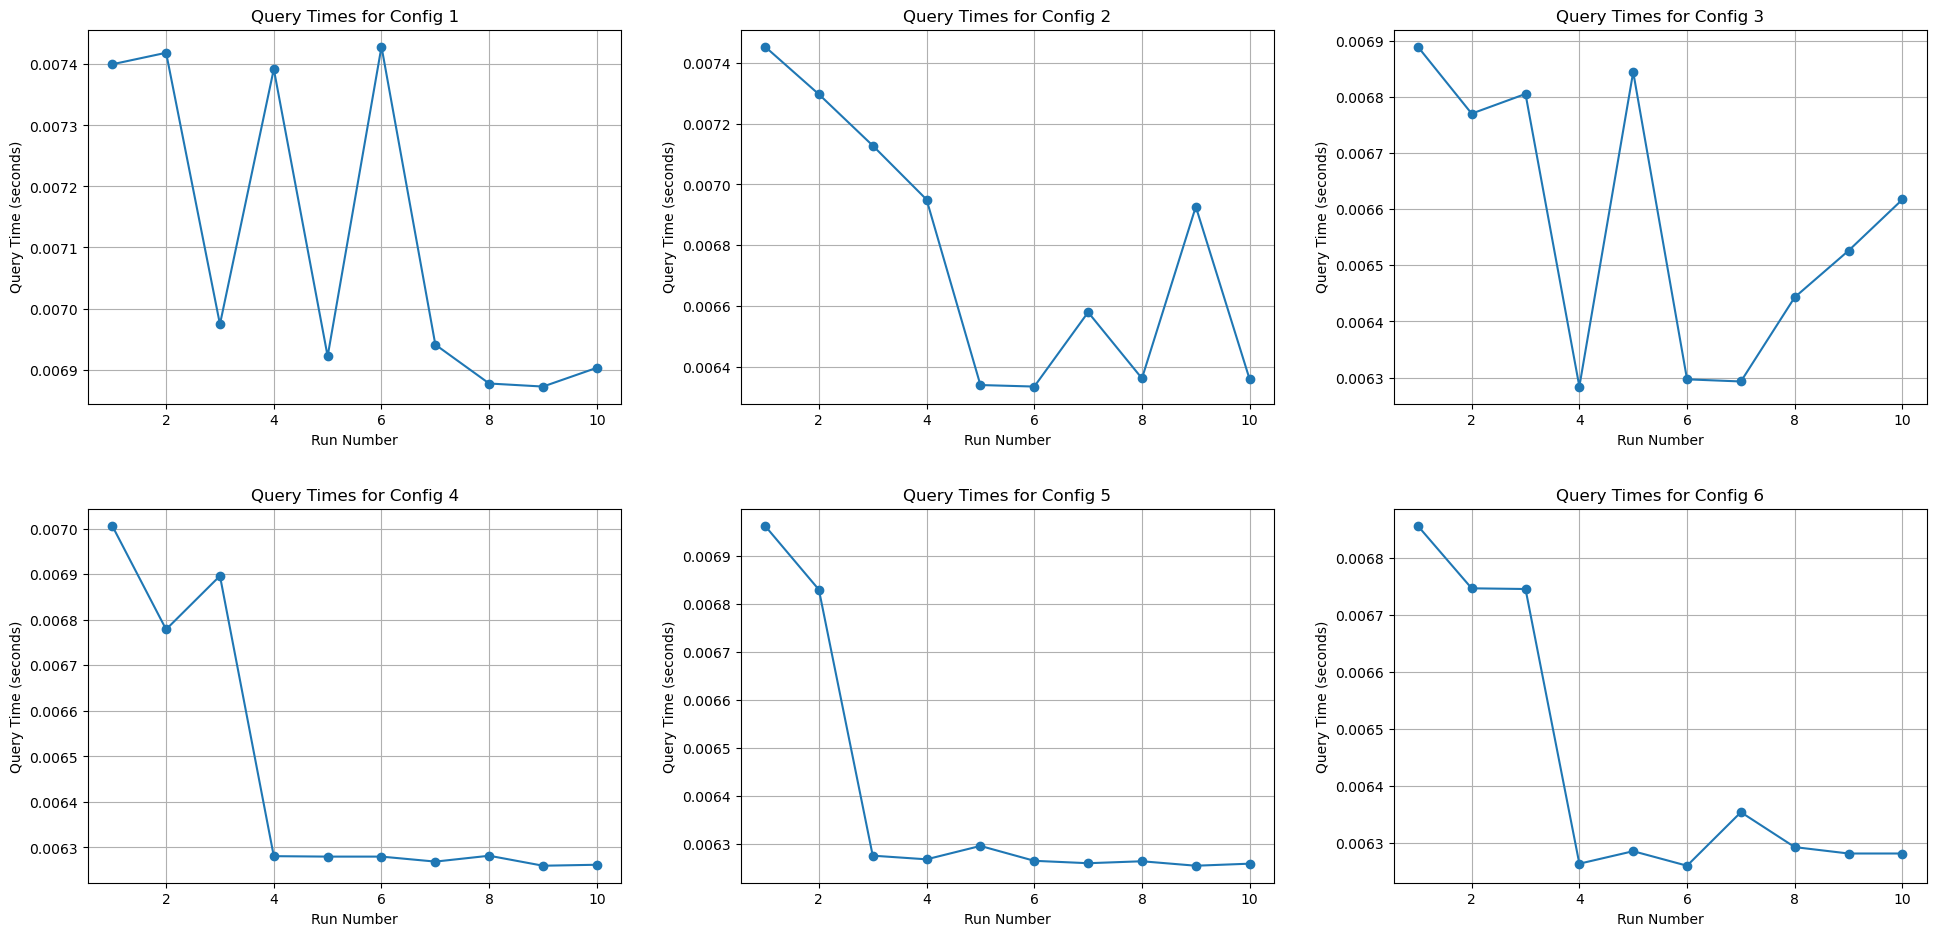

In [16]:
# Plotting the query times
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(epsilon_configs):
        ax.plot(range(1, 11), query_times[i], marker='o', linestyle='-')
        ax.set_title(f'Query Times for Config {i+1}')
        ax.set_xlabel('Run Number')
        ax.set_ylabel('Query Time (seconds)')
        ax.grid(True)
plt.tight_layout(pad=3.0)
plt.show()

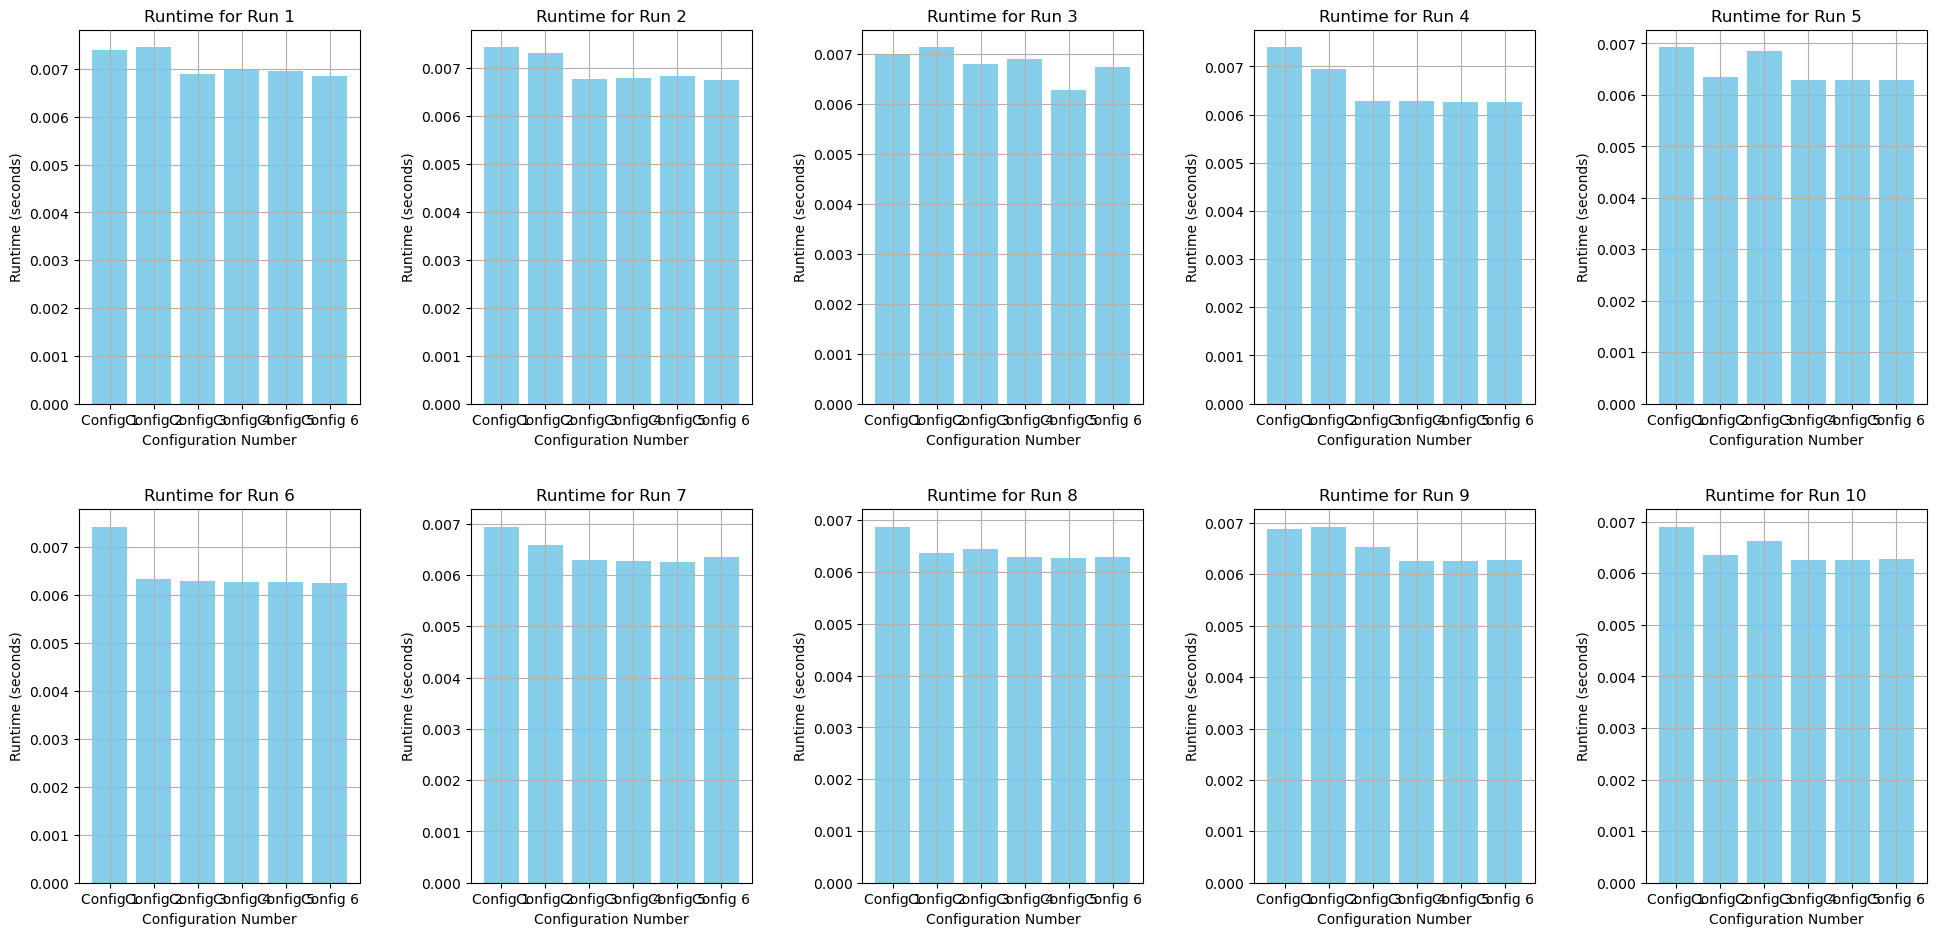

In [15]:
import matplotlib.pyplot as plt

# Assuming query_times is a list of lists where each sublist represents the runtimes for each configuration across 10 runs
# query_times = [[config1_run1, config1_run2, ..., config1_run10], ..., [config6_run1, ..., config6_run10]]

# Number of configurations and runs
num_configs = len(query_times)
num_runs = len(query_times[0])

# Prepare data for plotting
run_times_by_run = [[query_times[config][run] for config in range(num_configs)] for run in range(num_runs)]

# Plotting each run's data in a separate graph on a 2 by 5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust the overall size as needed
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for run in range(num_runs):
    axes[run].bar(range(1, num_configs + 1), run_times_by_run[run], color='skyblue')
    axes[run].set_xlabel('Configuration Number')
    axes[run].set_ylabel('Runtime (seconds)')
    axes[run].set_title(f'Runtime for Run {run + 1}')
    axes[run].set_xticks(range(1, num_configs + 1))
    axes[run].set_xticklabels([f'{i+1}' for i in range(num_configs)])
    axes[run].grid(True)

plt.tight_layout(pad=3.0)  # Adjust padding to prevent overlap
plt.show()

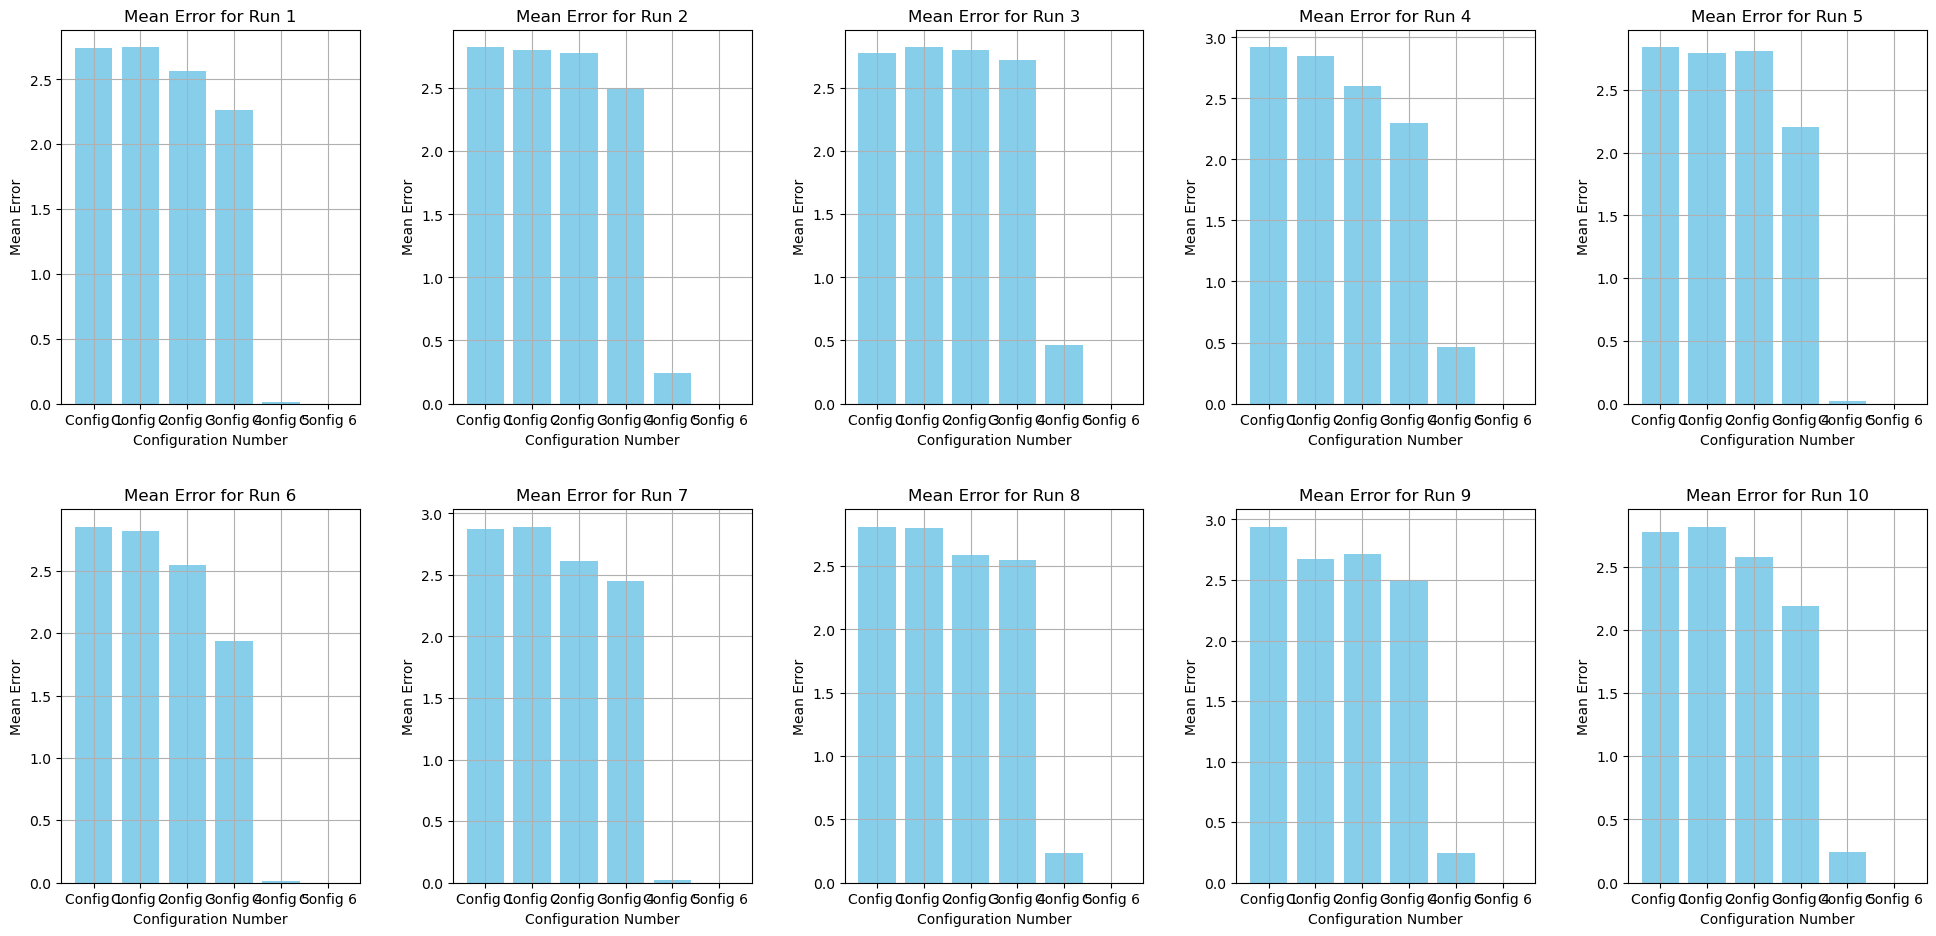

In [14]:
# Prepare data for plotting mean errors by each run across all configurations
mean_error_by_run = [[mean_errors[config][run] for config in range(num_configs)] for run in range(num_runs)]

# Plotting each run's data in a separate graph on a 2 by 5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust the overall size as needed
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for run in range(num_runs):
    axes[run].bar(range(1, num_configs + 1), mean_error_by_run[run], color='skyblue')
    axes[run].set_xlabel('Configuration Number')
    axes[run].set_ylabel('Mean Error')
    axes[run].set_title(f'Mean Error for Run {run + 1}')
    axes[run].set_xticks(range(1, num_configs + 1))
    axes[run].set_xticklabels([f'{i+1}' for i in range(num_configs)])
    axes[run].grid(True)

plt.tight_layout(pad=3.0)  # Adjust padding to prevent overlap
plt.show()

Query2.Student Grade Level

In [17]:
# Initialize a list to store query times for each config, for each of 10 runs
query_times = [[0] * 10 for _ in range(len(epsilon_configs))]
# Initialize a list to store mean errors for each config, for each of 10 runs
mean_errors = [[0] * 10 for _ in range(len(epsilon_configs))]

# Define the correct order for the grade levels
grade_order = ['PK', 'KF', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'OS']

# After noising, perform queries
for config_index, dfs in enumerate(noised_dfs_by_config):
    for run_index, noised_df in enumerate(dfs):
        start_time = time.time()
        grade_counts = noised_df['Student Grade Level'].value_counts()
        # Convert the grade levels in the index to a Categorical type with the defined order
        grade_counts.index = pd.Categorical(grade_counts.index, categories=grade_order, ordered=True)
        # Sort the Series by its index
        sorted_grade_counts = grade_counts.sort_index()
        query_times[config_index][run_index] = time.time() - start_time
        
        orig_distribution = NormalizedDistribution(df)
        noisy_distribution = NormalizedDistribution(noised_df)
        error_df = AbsPercentError(orig_distribution, noisy_distribution)
        mean_error = MeanAbsPercent(error_df)
        mean_errors[config_index][run_index] = mean_error

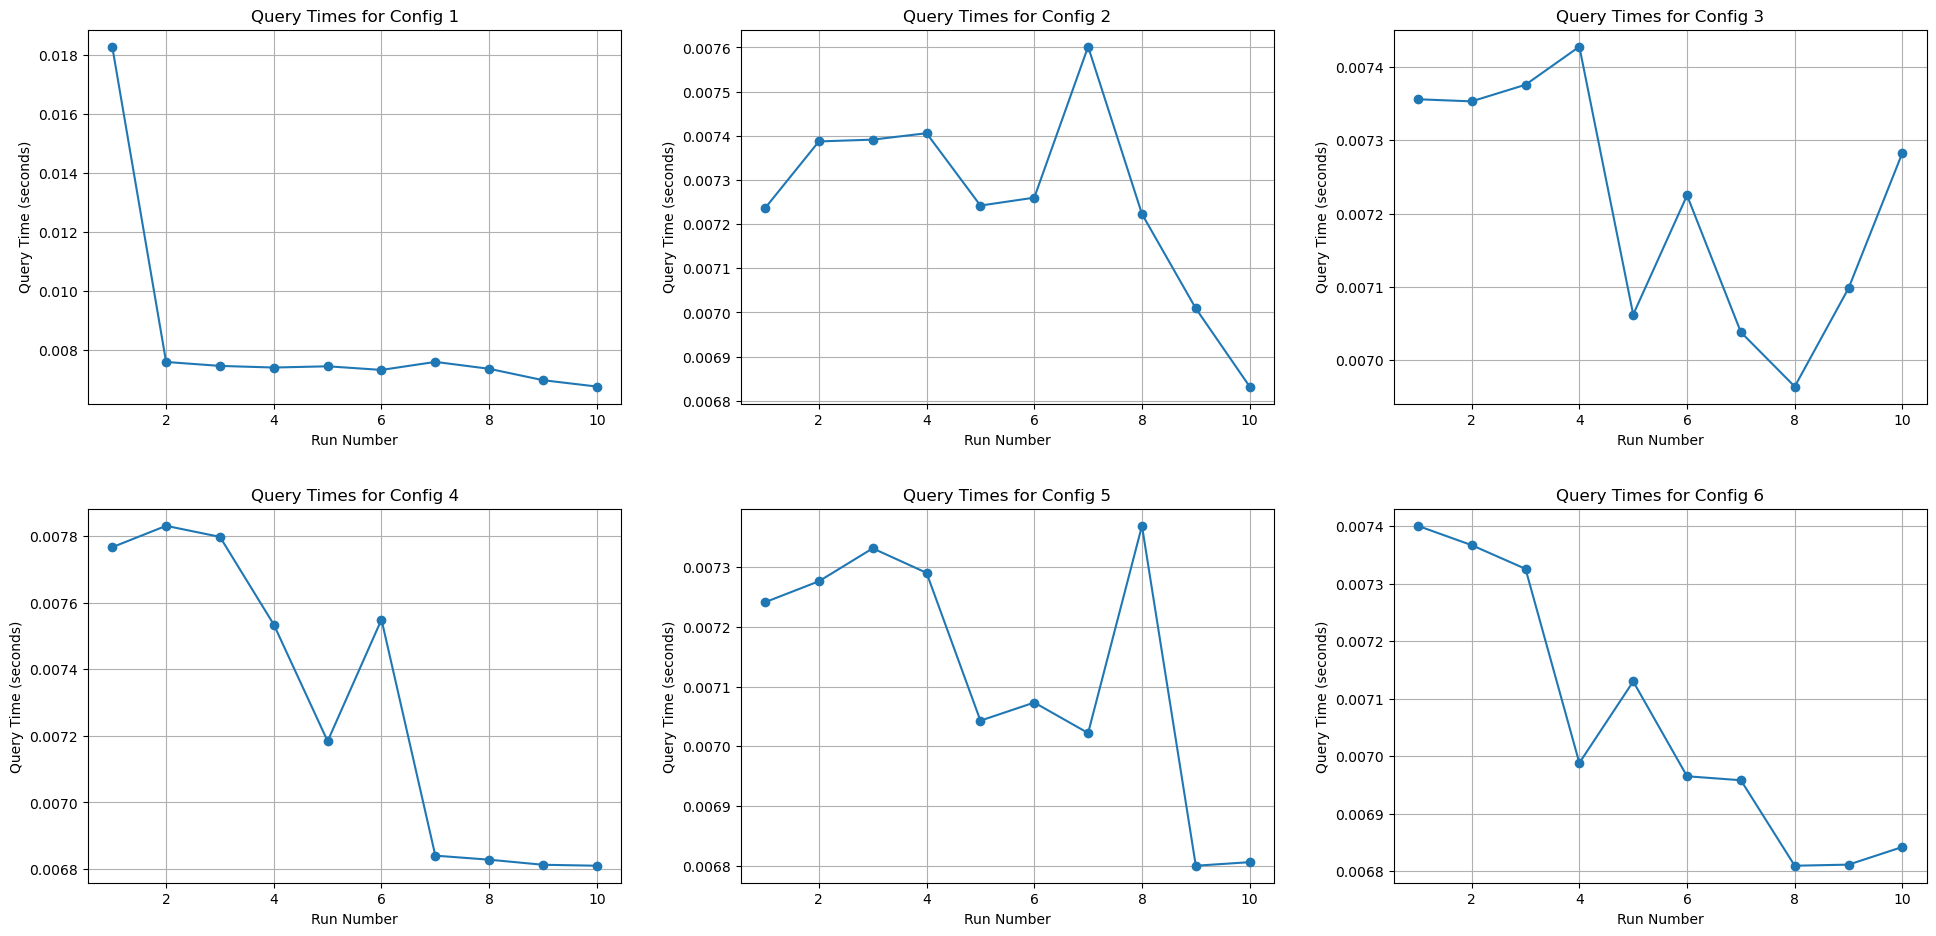

In [18]:
# Plotting the query times
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(epsilon_configs):
        ax.plot(range(1, 11), query_times[i], marker='o', linestyle='-')
        ax.set_title(f'Query Times for Config {i+1}')
        ax.set_xlabel('Run Number')
        ax.set_ylabel('Query Time (seconds)')
        ax.grid(True)
plt.tight_layout(pad=3.0)
plt.show()

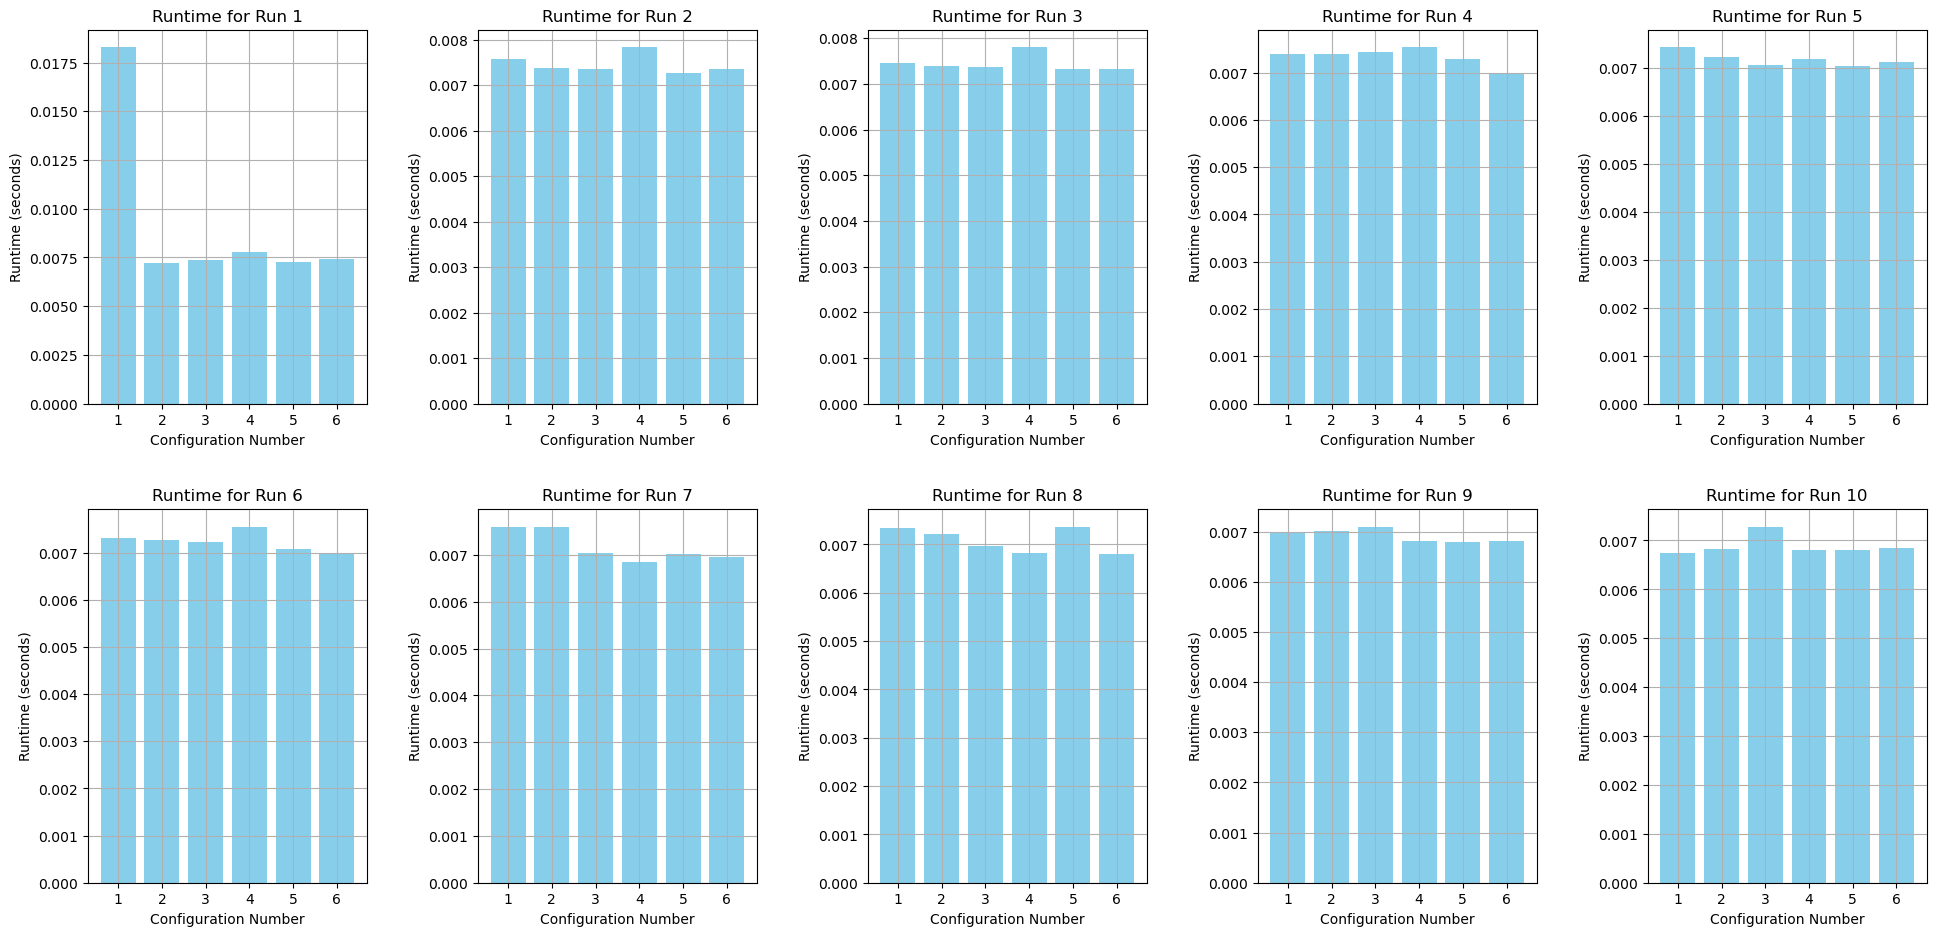

In [21]:
import matplotlib.pyplot as plt

# Assuming query_times is a list of lists where each sublist represents the runtimes for each configuration across 10 runs
# query_times = [[config1_run1, config1_run2, ..., config1_run10], ..., [config6_run1, ..., config6_run10]]

# Number of configurations and runs
num_configs = len(query_times)
num_runs = len(query_times[0])

# Prepare data for plotting
run_times_by_run = [[query_times[config][run] for config in range(num_configs)] for run in range(num_runs)]

# Plotting each run's data in a separate graph on a 2 by 5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust the overall size as needed
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for run in range(num_runs):
    axes[run].bar(range(1, num_configs + 1), run_times_by_run[run], color='skyblue')
    axes[run].set_xlabel('Configuration Number')
    axes[run].set_ylabel('Runtime (seconds)')
    axes[run].set_title(f'Runtime for Run {run + 1}')
    axes[run].set_xticks(range(1, num_configs + 1))
    axes[run].set_xticklabels([f'{i+1}' for i in range(num_configs)])
    axes[run].grid(True)

plt.tight_layout(pad=3.0)  # Adjust padding to prevent overlap
plt.show()

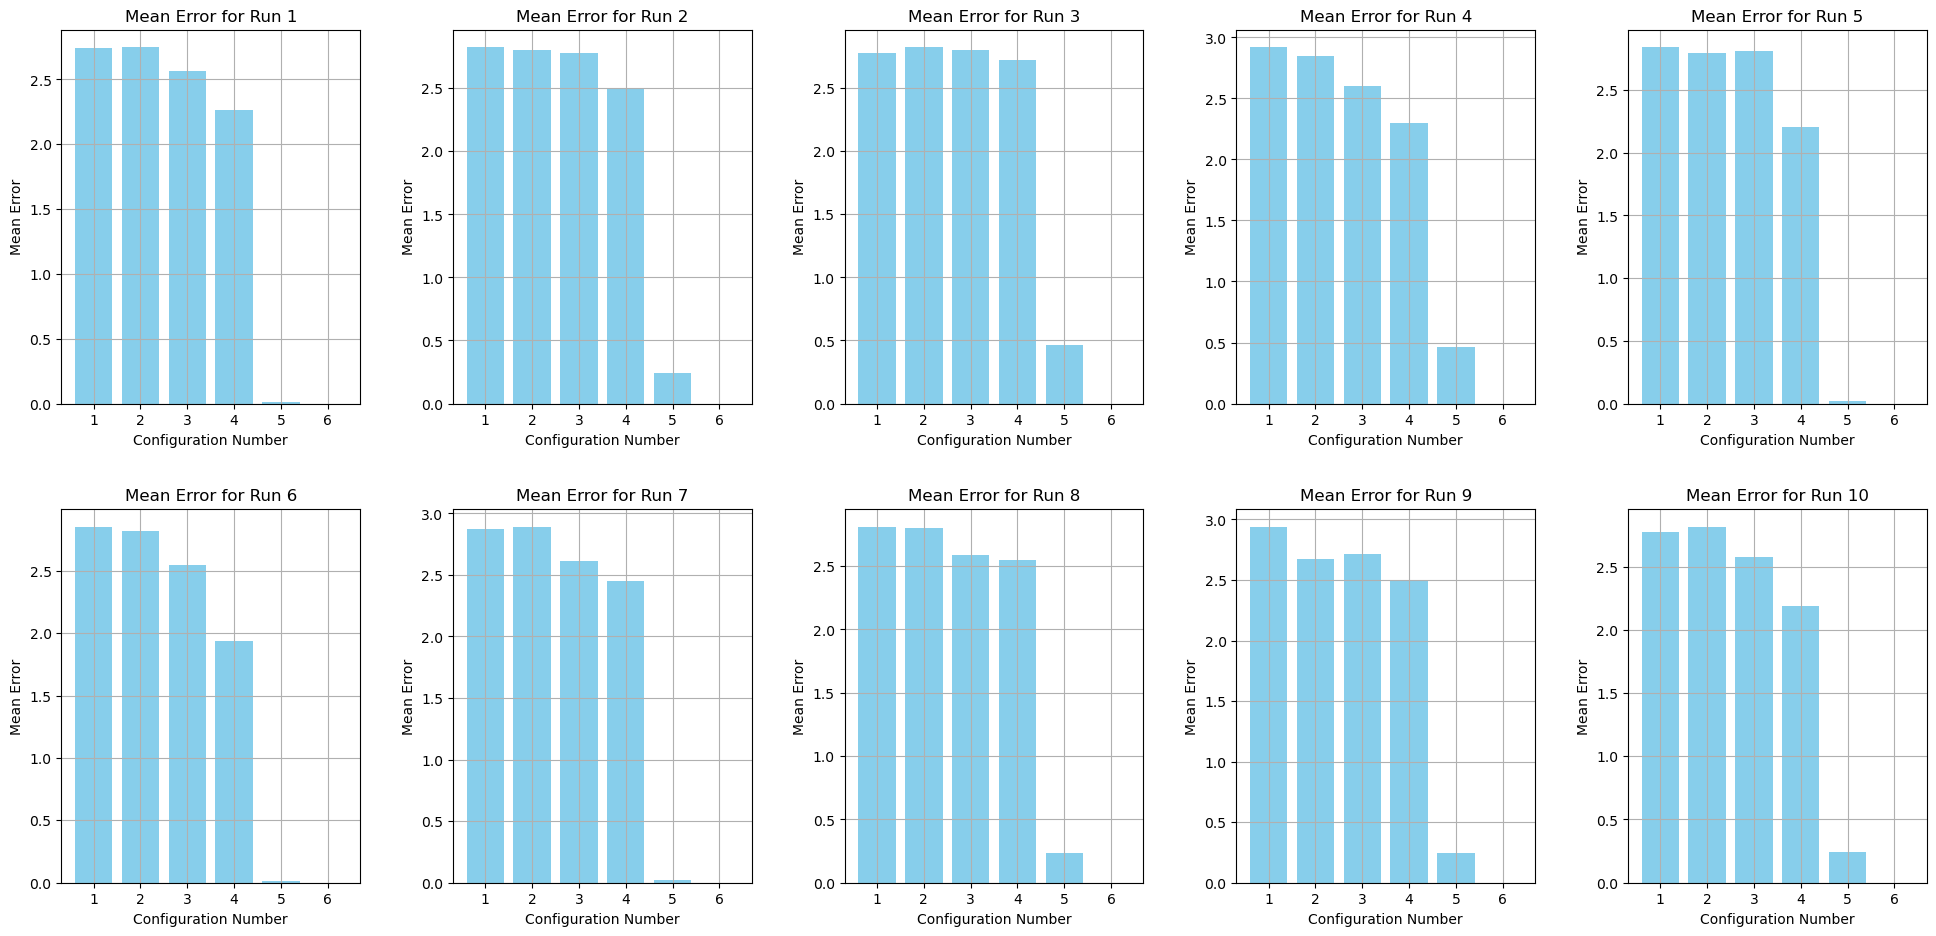

In [22]:
# Prepare data for plotting mean errors by each run across all configurations
mean_error_by_run = [[mean_errors[config][run] for config in range(num_configs)] for run in range(num_runs)]

# Plotting each run's data in a separate graph on a 2 by 5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust the overall size as needed
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for run in range(num_runs):
    axes[run].bar(range(1, num_configs + 1), mean_error_by_run[run], color='skyblue')
    axes[run].set_xlabel('Configuration Number')
    axes[run].set_ylabel('Mean Error')
    axes[run].set_title(f'Mean Error for Run {run + 1}')
    axes[run].set_xticks(range(1, num_configs + 1))
    axes[run].set_xticklabels([f'{i+1}' for i in range(num_configs)])
    axes[run].grid(True)

plt.tight_layout(pad=3.0)  # Adjust padding to prevent overlap
plt.show()

Query3.Racial Bias

In [23]:
# Initialize a list to store query times for each config, for each of 10 runs
query_times = [[0] * 10 for _ in range(len(epsilon_configs))]
# Initialize a list to store mean errors for each config, for each of 10 runs
mean_errors = [[0] * 10 for _ in range(len(epsilon_configs))]

# Map race names to initials
race_initials = {
    'Caucasian': 'W',
    'Black or African American': 'B',
    'Hispanic': 'H',
    'American Indian/Alaskan Native': 'AI/AN',
    'Multiracial': 'M',
    'Native Hawaiian or Other Pacific Islander': 'NH/OPI',
    'Asian': 'A',
}     

# After noising, perform queries
for config_index, dfs in enumerate(noised_dfs_by_config):
    for run_index, noised_df in enumerate(dfs):
        start_time = time.time()
        # Add a new column with race initials
        noised_df['Race Initials'] = noised_df['Student Race Ethnicity Derived'].map(race_initials)
        # Group by Race Initials and Punishment Type, and count the occurrences
        punishment_counts = noised_df.groupby(['Race Initials', 'Discipline Response']).size().unstack(fill_value=0)
        # Normalize the counts by the total number of infractions for each race
        normalized_counts = punishment_counts.div(punishment_counts.sum(axis=1), axis=0)
        query_times[config_index][run_index] = time.time() - start_time
        
        orig_distribution = NormalizedDistribution(df)
        noisy_distribution = NormalizedDistribution(noised_df)
        error_df = AbsPercentError(orig_distribution, noisy_distribution)
        mean_error = MeanAbsPercent(error_df)
        mean_errors[config_index][run_index] = mean_error

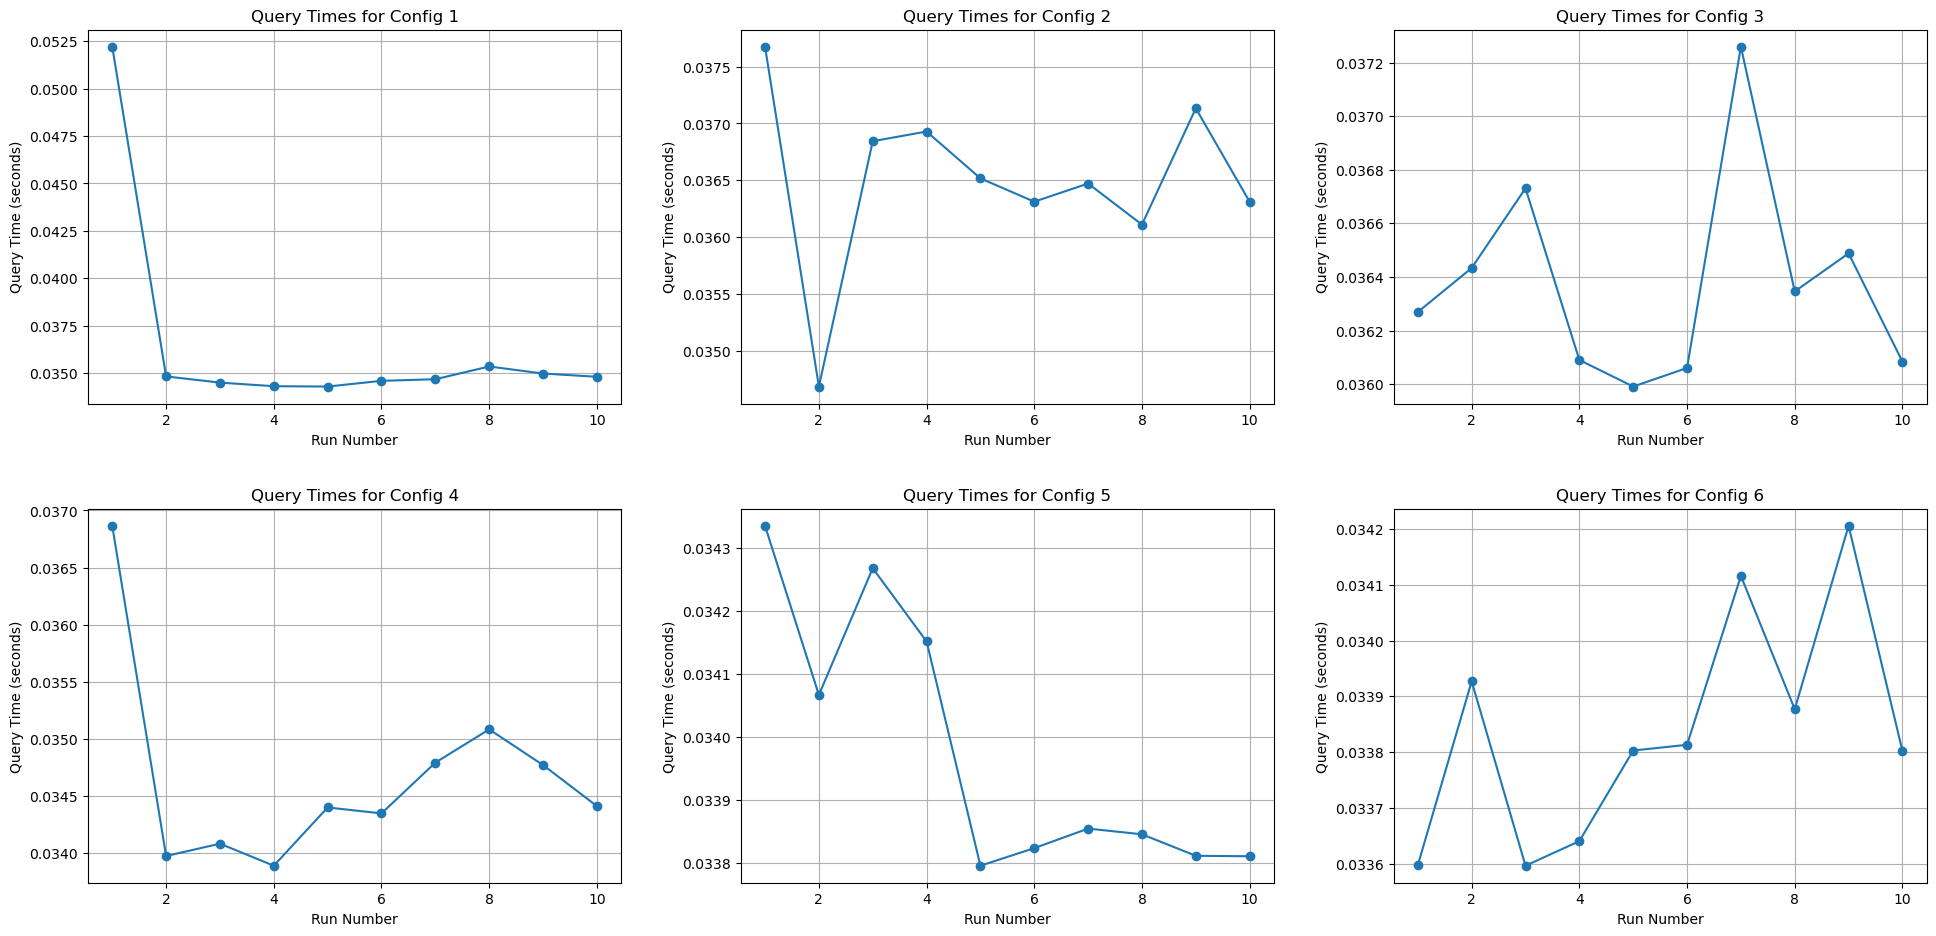

In [24]:
# Plotting the query times
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(epsilon_configs):
        ax.plot(range(1, 11), query_times[i], marker='o', linestyle='-')
        ax.set_title(f'Query Times for Config {i+1}')
        ax.set_xlabel('Run Number')
        ax.set_ylabel('Query Time (seconds)')
        ax.grid(True)
plt.tight_layout(pad=3.0)
plt.show()

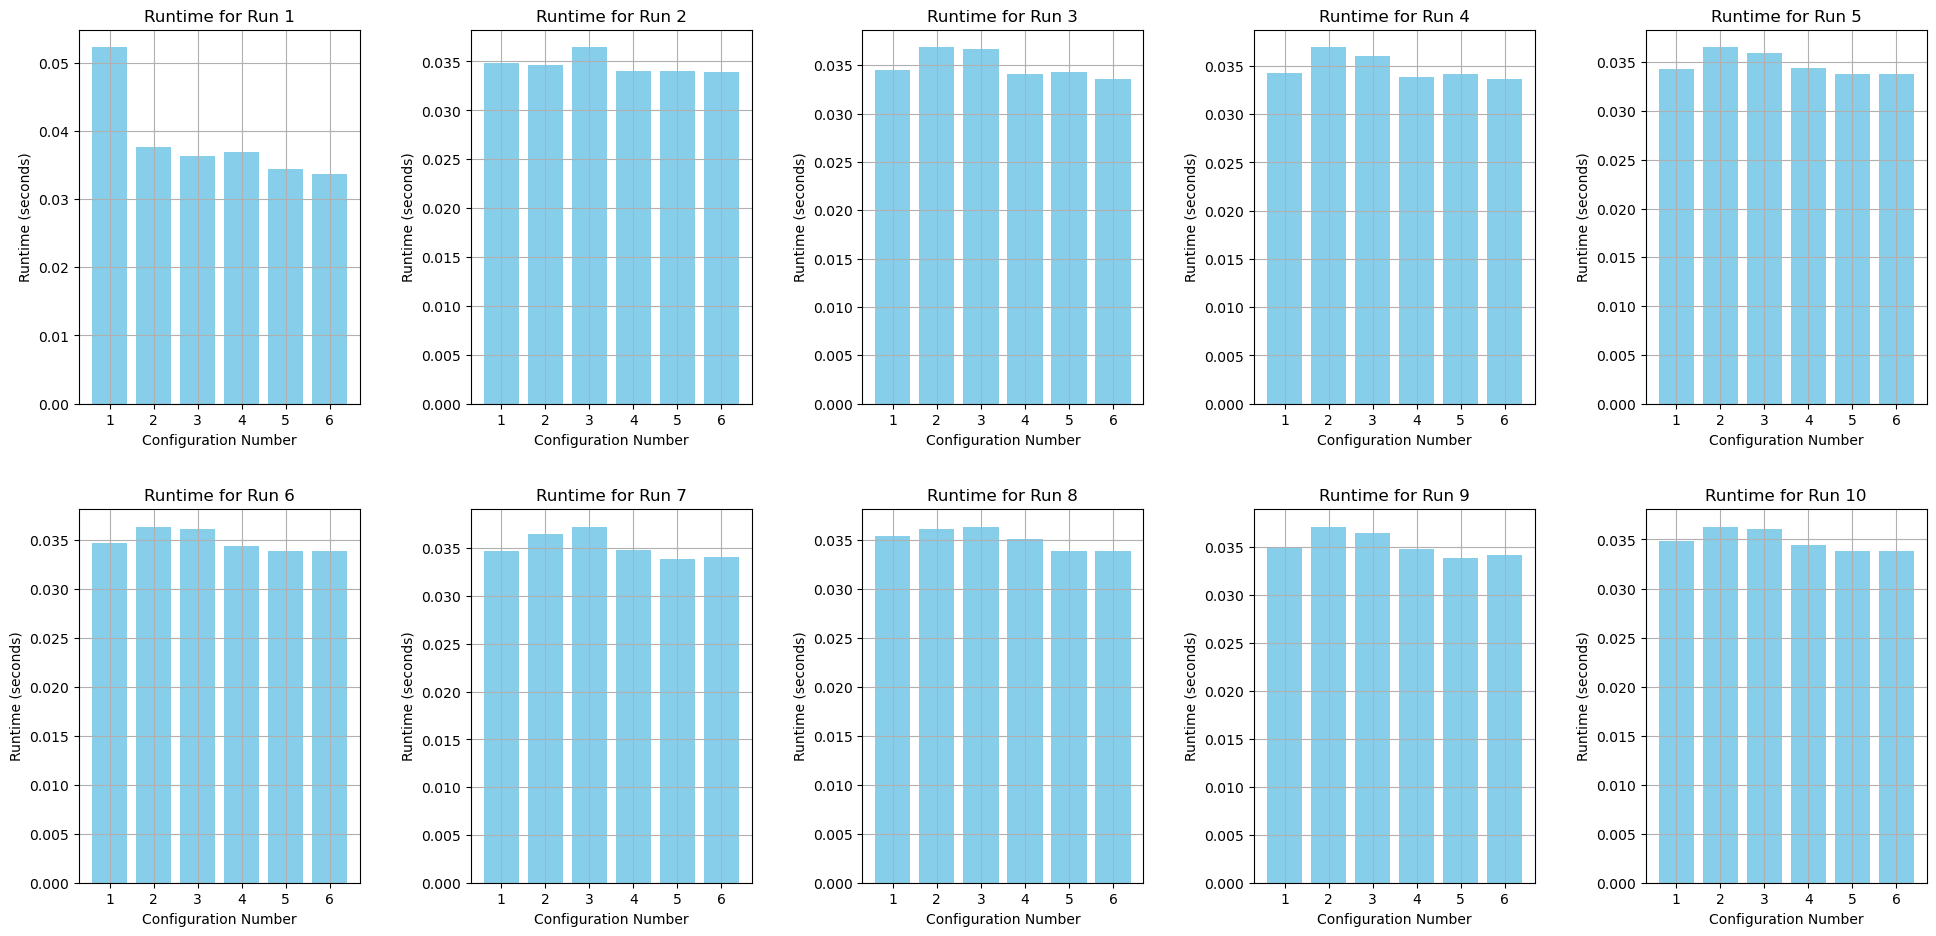

In [25]:
import matplotlib.pyplot as plt

# Assuming query_times is a list of lists where each sublist represents the runtimes for each configuration across 10 runs
# query_times = [[config1_run1, config1_run2, ..., config1_run10], ..., [config6_run1, ..., config6_run10]]

# Number of configurations and runs
num_configs = len(query_times)
num_runs = len(query_times[0])

# Prepare data for plotting
run_times_by_run = [[query_times[config][run] for config in range(num_configs)] for run in range(num_runs)]

# Plotting each run's data in a separate graph on a 2 by 5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust the overall size as needed
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for run in range(num_runs):
    axes[run].bar(range(1, num_configs + 1), run_times_by_run[run], color='skyblue')
    axes[run].set_xlabel('Configuration Number')
    axes[run].set_ylabel('Runtime (seconds)')
    axes[run].set_title(f'Runtime for Run {run + 1}')
    axes[run].set_xticks(range(1, num_configs + 1))
    axes[run].set_xticklabels([f'{i+1}' for i in range(num_configs)])
    axes[run].grid(True)

plt.tight_layout(pad=3.0)  # Adjust padding to prevent overlap
plt.show()

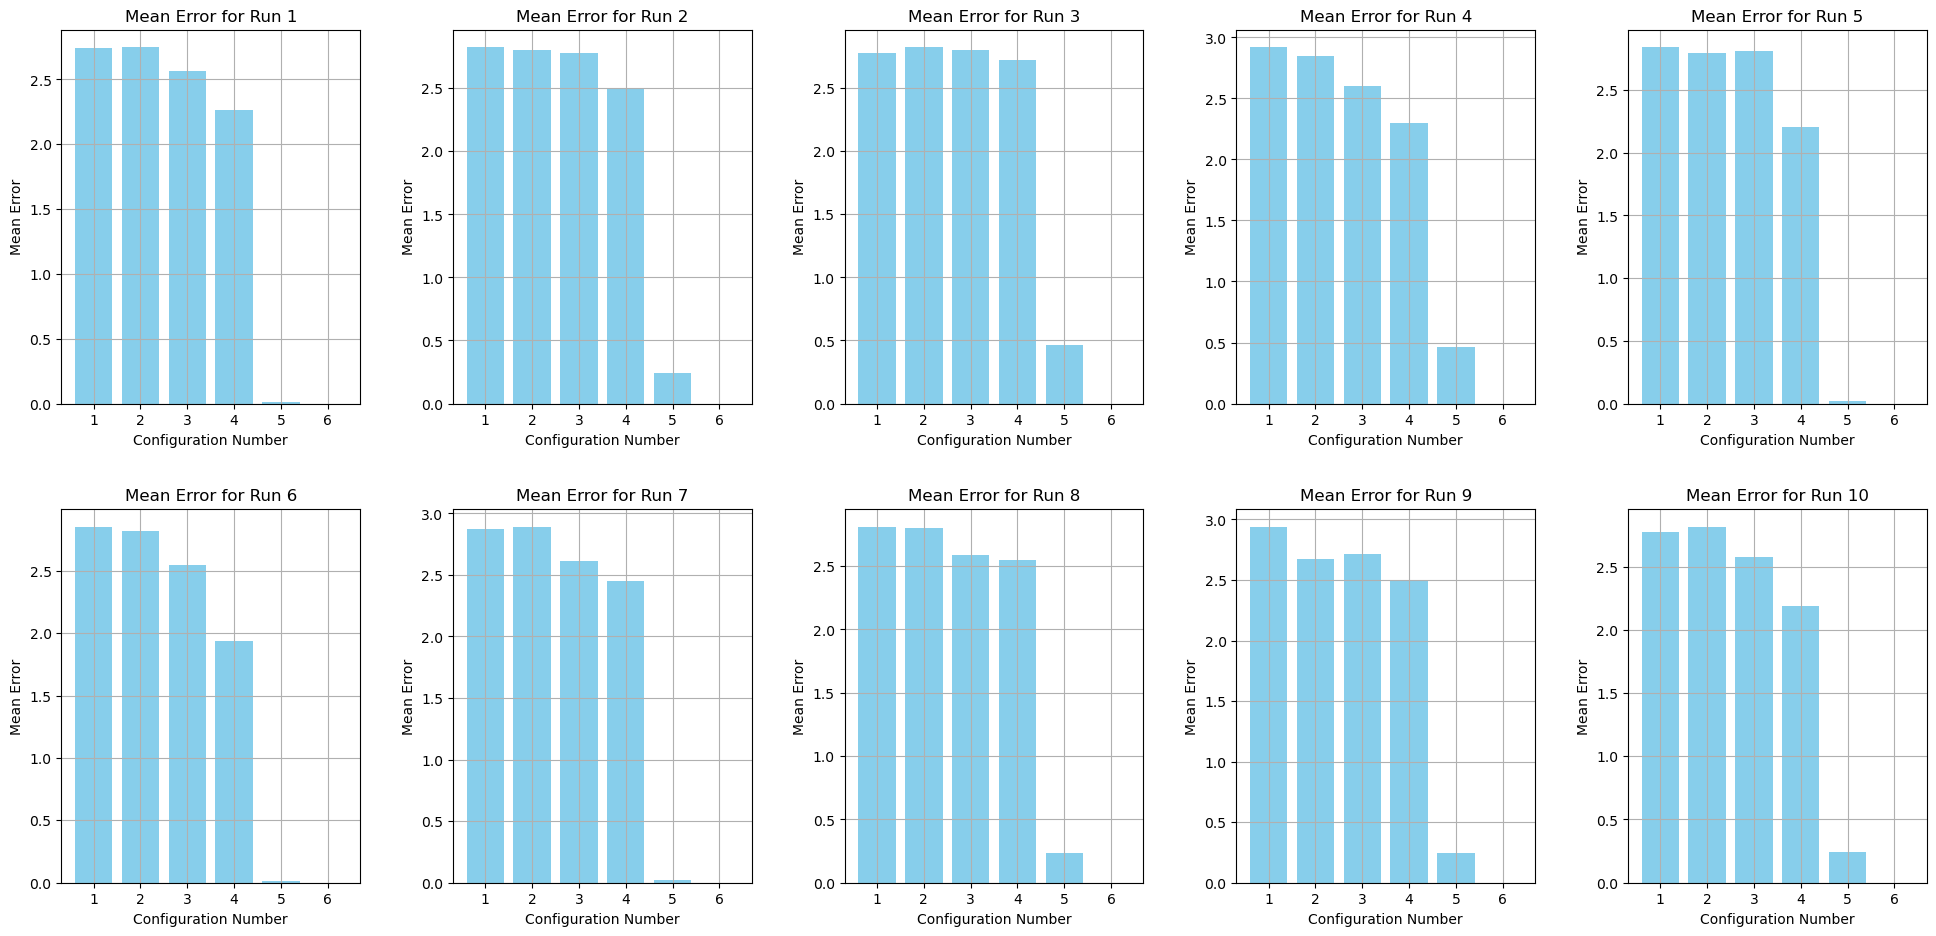

In [26]:
# Prepare data for plotting mean errors by each run across all configurations
mean_error_by_run = [[mean_errors[config][run] for config in range(num_configs)] for run in range(num_runs)]

# Plotting each run's data in a separate graph on a 2 by 5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust the overall size as needed
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for run in range(num_runs):
    axes[run].bar(range(1, num_configs + 1), mean_error_by_run[run], color='skyblue')
    axes[run].set_xlabel('Configuration Number')
    axes[run].set_ylabel('Mean Error')
    axes[run].set_title(f'Mean Error for Run {run + 1}')
    axes[run].set_xticks(range(1, num_configs + 1))
    axes[run].set_xticklabels([f'{i+1}' for i in range(num_configs)])
    axes[run].grid(True)

plt.tight_layout(pad=3.0)  # Adjust padding to prevent overlap
plt.show()

Query4.Drug Related

In [27]:
import time
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a list to store query times for each config, for each of 10 runs
query_times = [[0] * 10 for _ in range(len(epsilon_configs))]
# Initialize a list to store mean errors for each config, for each of 10 runs
mean_errors = [[0] * 10 for _ in range(len(epsilon_configs))]

# After noising, perform queries
for config_index, dfs in enumerate(noised_dfs_by_config):
    for run_index, noised_df in enumerate(dfs):
        start_time = time.time()
        drug_related = noised_df['Drug Related'].value_counts()
        query_times[config_index][run_index] = time.time() - start_time
        
        orig_distribution = NormalizedDistribution(df)
        noisy_distribution = NormalizedDistribution(noised_df)
        error_df = AbsPercentError(orig_distribution, noisy_distribution)
        mean_error = MeanAbsPercent(error_df)
        mean_errors[config_index][run_index] = mean_error

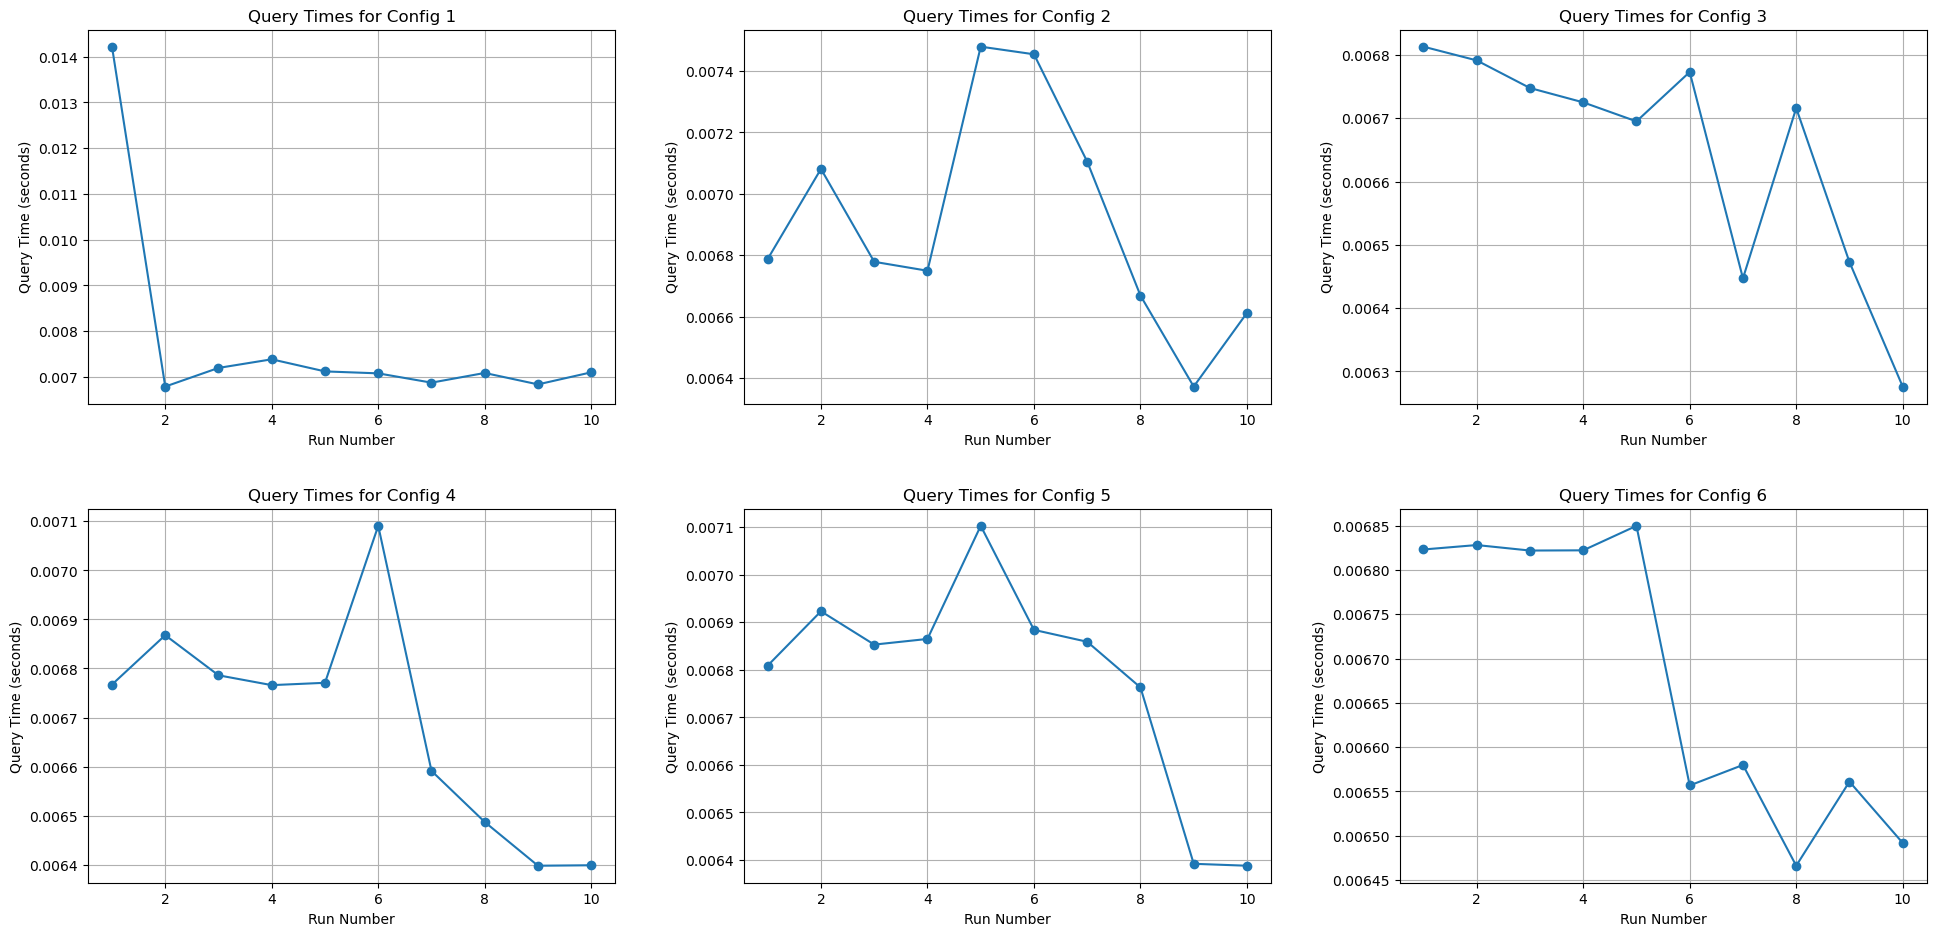

In [28]:
# Plotting the query times
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(epsilon_configs):
        ax.plot(range(1, 11), query_times[i], marker='o', linestyle='-')
        ax.set_title(f'Query Times for Config {i+1}')
        ax.set_xlabel('Run Number')
        ax.set_ylabel('Query Time (seconds)')
        ax.grid(True)
plt.tight_layout(pad=3.0)
plt.show()

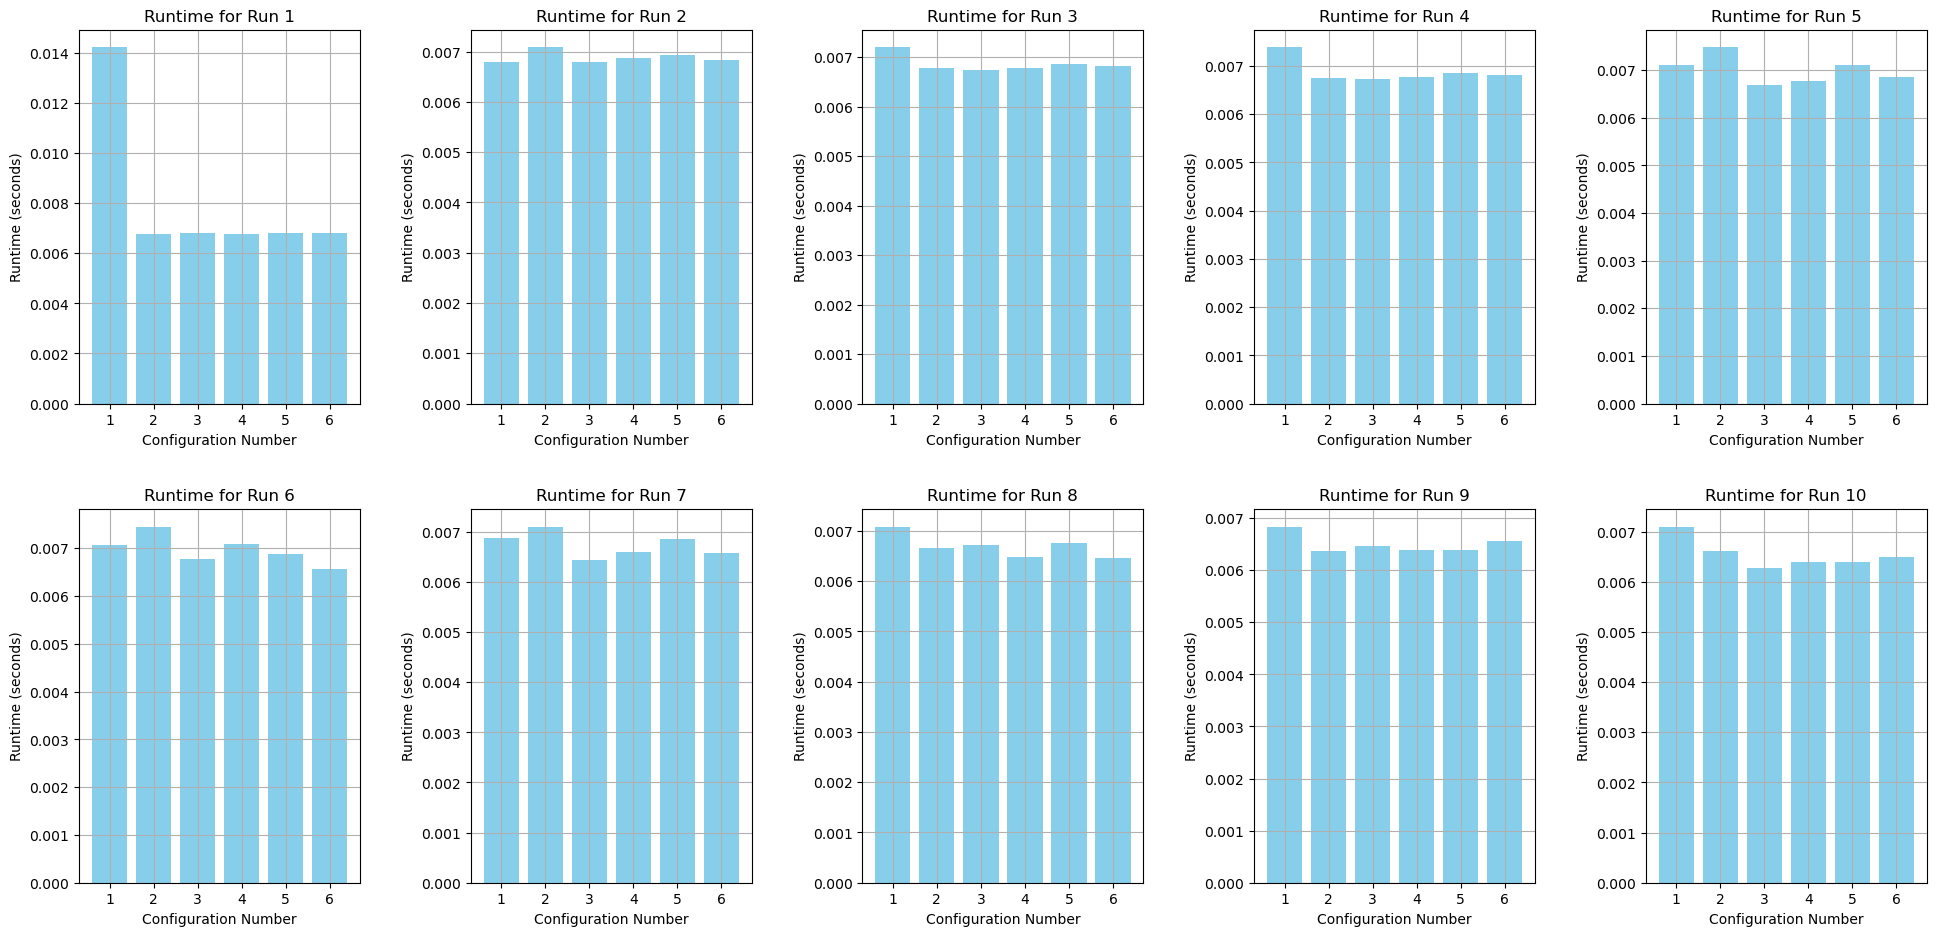

In [29]:
import matplotlib.pyplot as plt

# Assuming query_times is a list of lists where each sublist represents the runtimes for each configuration across 10 runs
# query_times = [[config1_run1, config1_run2, ..., config1_run10], ..., [config6_run1, ..., config6_run10]]

# Number of configurations and runs
num_configs = len(query_times)
num_runs = len(query_times[0])

# Prepare data for plotting
run_times_by_run = [[query_times[config][run] for config in range(num_configs)] for run in range(num_runs)]

# Plotting each run's data in a separate graph on a 2 by 5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust the overall size as needed
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for run in range(num_runs):
    axes[run].bar(range(1, num_configs + 1), run_times_by_run[run], color='skyblue')
    axes[run].set_xlabel('Configuration Number')
    axes[run].set_ylabel('Runtime (seconds)')
    axes[run].set_title(f'Runtime for Run {run + 1}')
    axes[run].set_xticks(range(1, num_configs + 1))
    axes[run].set_xticklabels([f'{i+1}' for i in range(num_configs)])
    axes[run].grid(True)

plt.tight_layout(pad=3.0)  # Adjust padding to prevent overlap
plt.show()

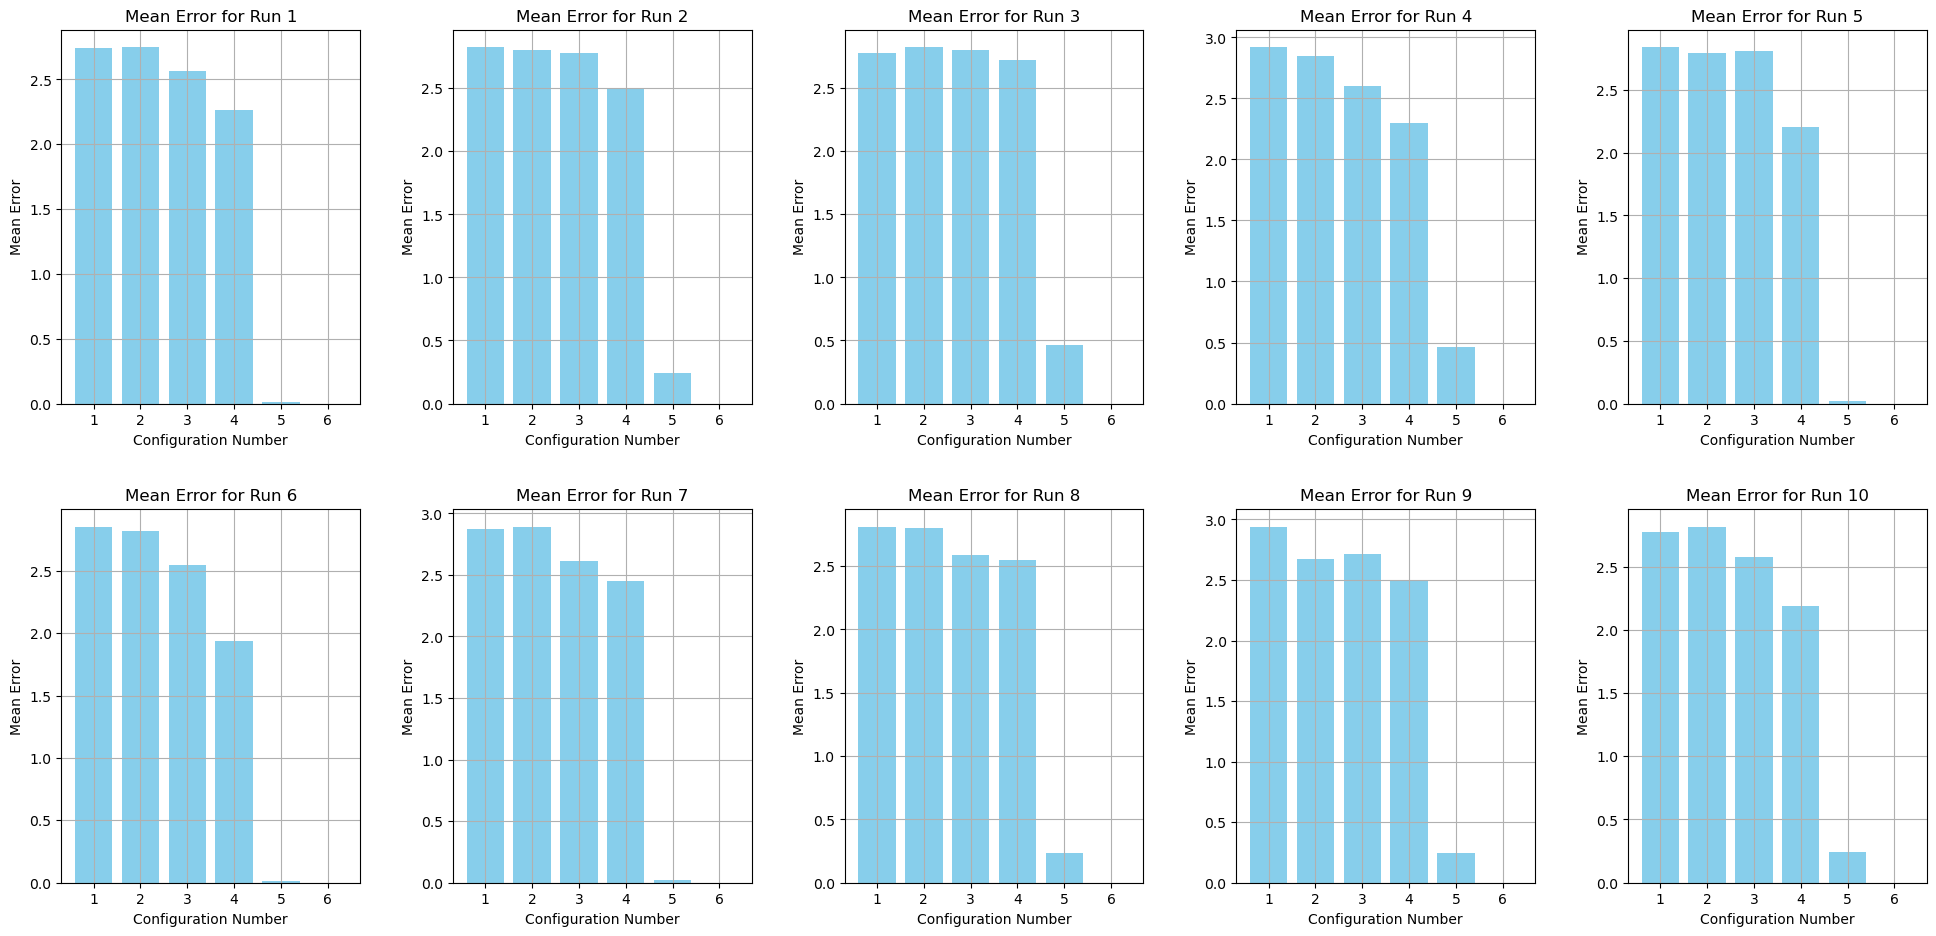

In [30]:
# Prepare data for plotting mean errors by each run across all configurations
mean_error_by_run = [[mean_errors[config][run] for config in range(num_configs)] for run in range(num_runs)]

# Plotting each run's data in a separate graph on a 2 by 5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust the overall size as needed
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for run in range(num_runs):
    axes[run].bar(range(1, num_configs + 1), mean_error_by_run[run], color='skyblue')
    axes[run].set_xlabel('Configuration Number')
    axes[run].set_ylabel('Mean Error')
    axes[run].set_title(f'Mean Error for Run {run + 1}')
    axes[run].set_xticks(range(1, num_configs + 1))
    axes[run].set_xticklabels([f'{i+1}' for i in range(num_configs)])
    axes[run].grid(True)

plt.tight_layout(pad=3.0)  # Adjust padding to prevent overlap
plt.show()

Query5.Gender Discipline

In [33]:
import time
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a list to store query times for each config, for each of 10 runs
query_times = [[0] * 10 for _ in range(len(epsilon_configs))]
# Initialize a list to store mean errors for each config, for each of 10 runs
mean_errors = [[0] * 10 for _ in range(len(epsilon_configs))]

# After noising, perform queries
for config_index, dfs in enumerate(noised_dfs_by_config):
    for run_index, noised_df in enumerate(dfs):
        start_time = time.time()
        # Calculate total occurrences of each infraction and get top 10
        total_infractions = noised_df['Discipline Infraction'].value_counts().nlargest(10)
        top_infractions = total_infractions.index.tolist()
        # Filter the DataFrame to include only the top 10 infractions
        filtered_df = df[df['Discipline Infraction'].isin(top_infractions)]
        # Group by gender and infraction, then calculate size and unstack for plotting
        infraction_counts = filtered_df.groupby(['Student Gender Code', 'Discipline Infraction']).size().unstack(fill_value=0)
        # Normalize the counts to show proportions
        normalized_counts = infraction_counts.div(infraction_counts.sum(axis=1), axis=0)
        query_times[config_index][run_index] = time.time() - start_time
        
        orig_distribution = NormalizedDistribution(df)
        noisy_distribution = NormalizedDistribution(noised_df)
        error_df = AbsPercentError(orig_distribution, noisy_distribution)
        mean_error = MeanAbsPercent(error_df)
        mean_errors[config_index][run_index] = mean_error

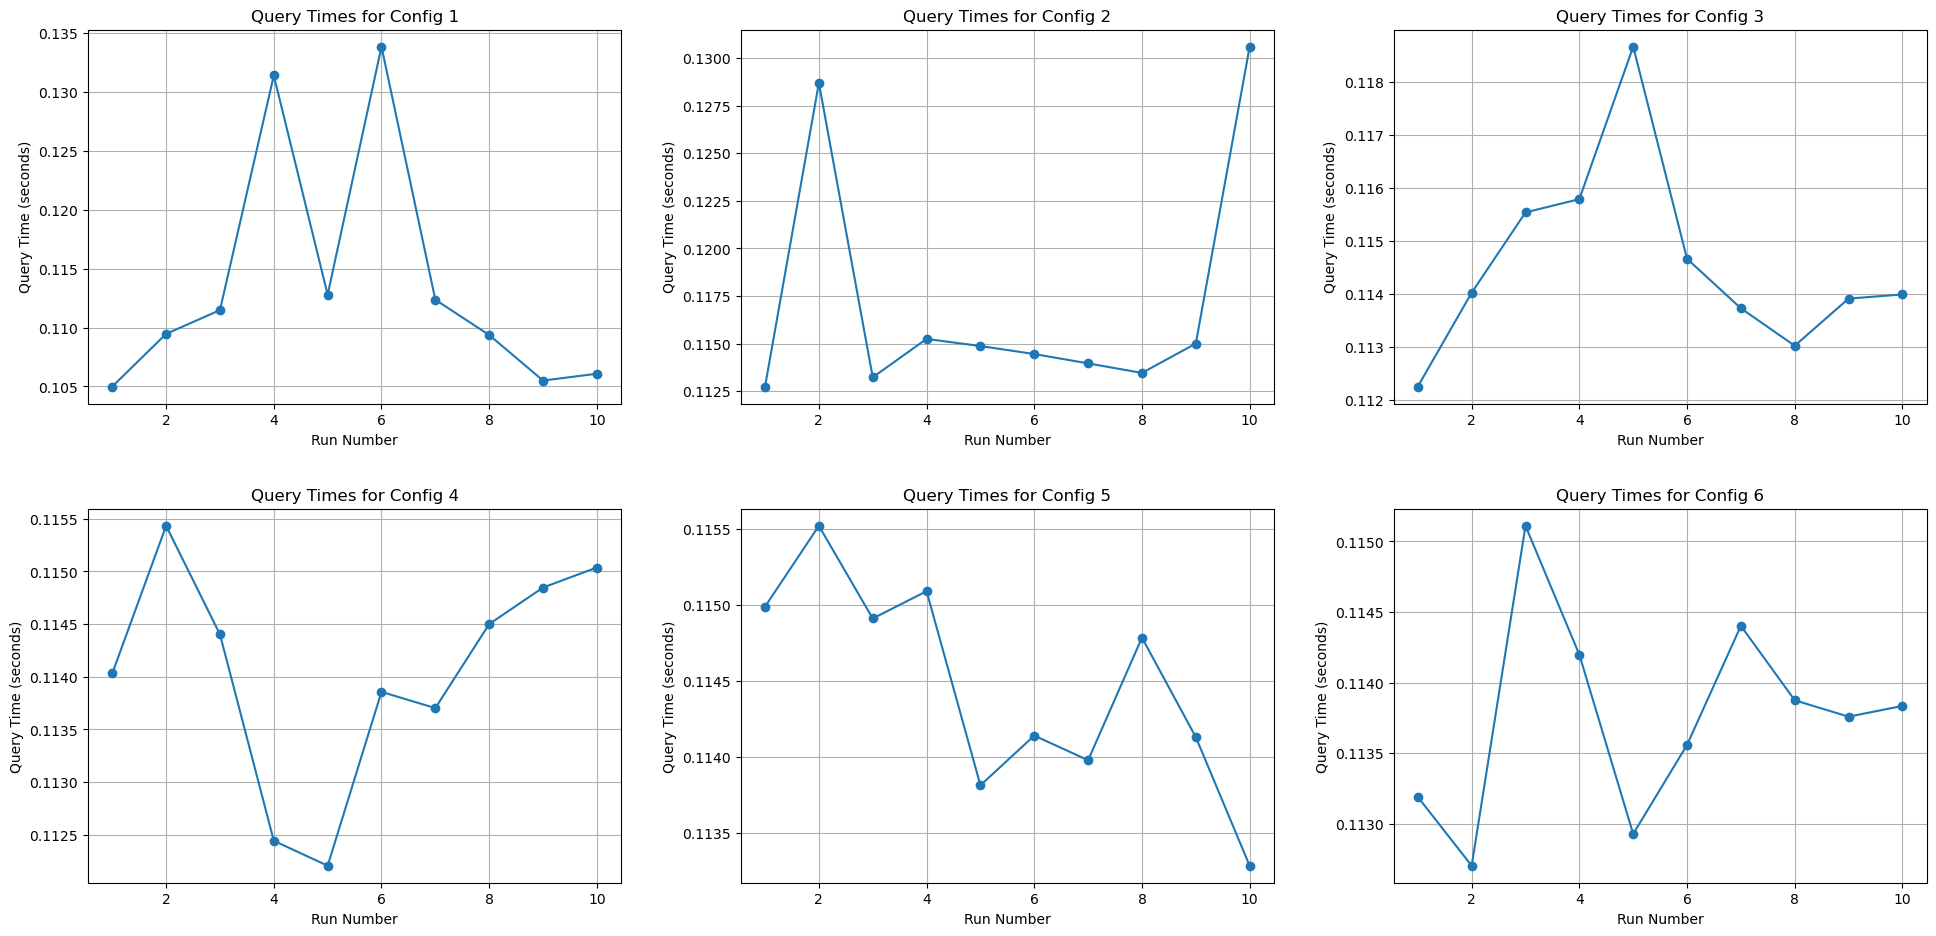

In [34]:
# Plotting the query times
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(epsilon_configs):
        ax.plot(range(1, 11), query_times[i], marker='o', linestyle='-')
        ax.set_title(f'Query Times for Config {i+1}')
        ax.set_xlabel('Run Number')
        ax.set_ylabel('Query Time (seconds)')
        ax.grid(True)
plt.tight_layout(pad=3.0)
plt.show()

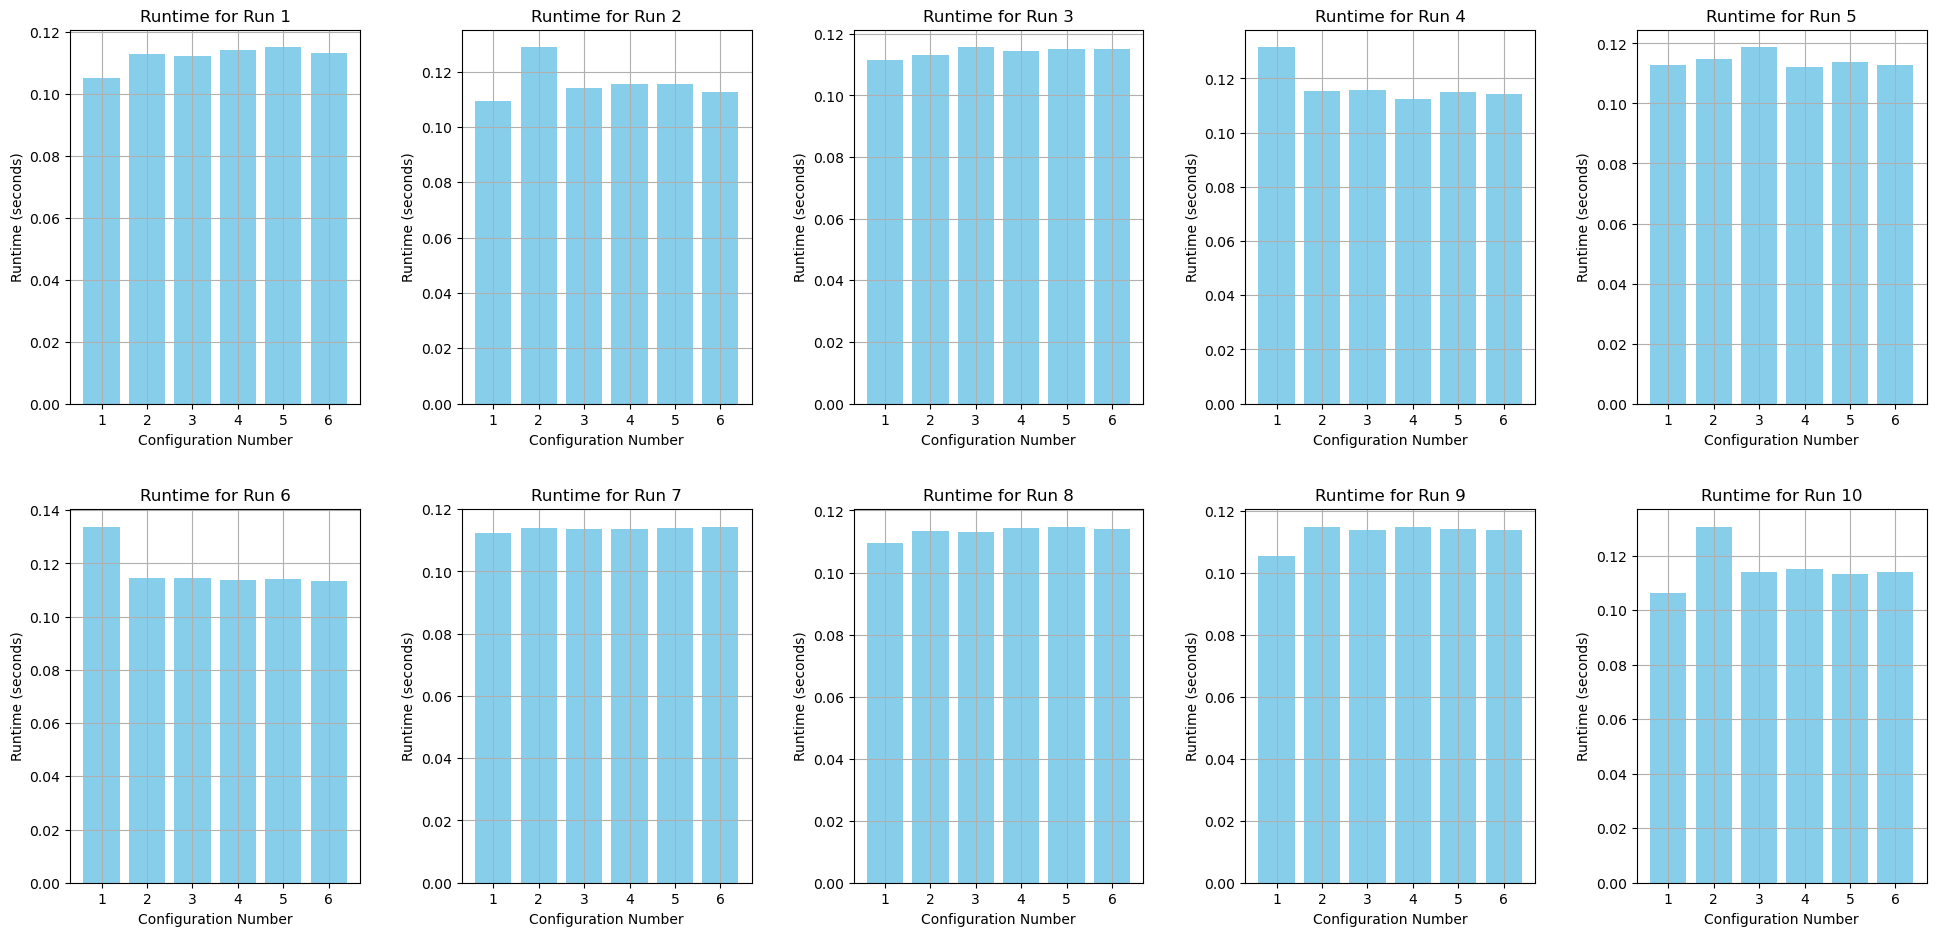

In [35]:
import matplotlib.pyplot as plt

# Assuming query_times is a list of lists where each sublist represents the runtimes for each configuration across 10 runs
# query_times = [[config1_run1, config1_run2, ..., config1_run10], ..., [config6_run1, ..., config6_run10]]

# Number of configurations and runs
num_configs = len(query_times)
num_runs = len(query_times[0])

# Prepare data for plotting
run_times_by_run = [[query_times[config][run] for config in range(num_configs)] for run in range(num_runs)]

# Plotting each run's data in a separate graph on a 2 by 5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust the overall size as needed
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for run in range(num_runs):
    axes[run].bar(range(1, num_configs + 1), run_times_by_run[run], color='skyblue')
    axes[run].set_xlabel('Configuration Number')
    axes[run].set_ylabel('Runtime (seconds)')
    axes[run].set_title(f'Runtime for Run {run + 1}')
    axes[run].set_xticks(range(1, num_configs + 1))
    axes[run].set_xticklabels([f'{i+1}' for i in range(num_configs)])
    axes[run].grid(True)

plt.tight_layout(pad=3.0)  # Adjust padding to prevent overlap
plt.show()

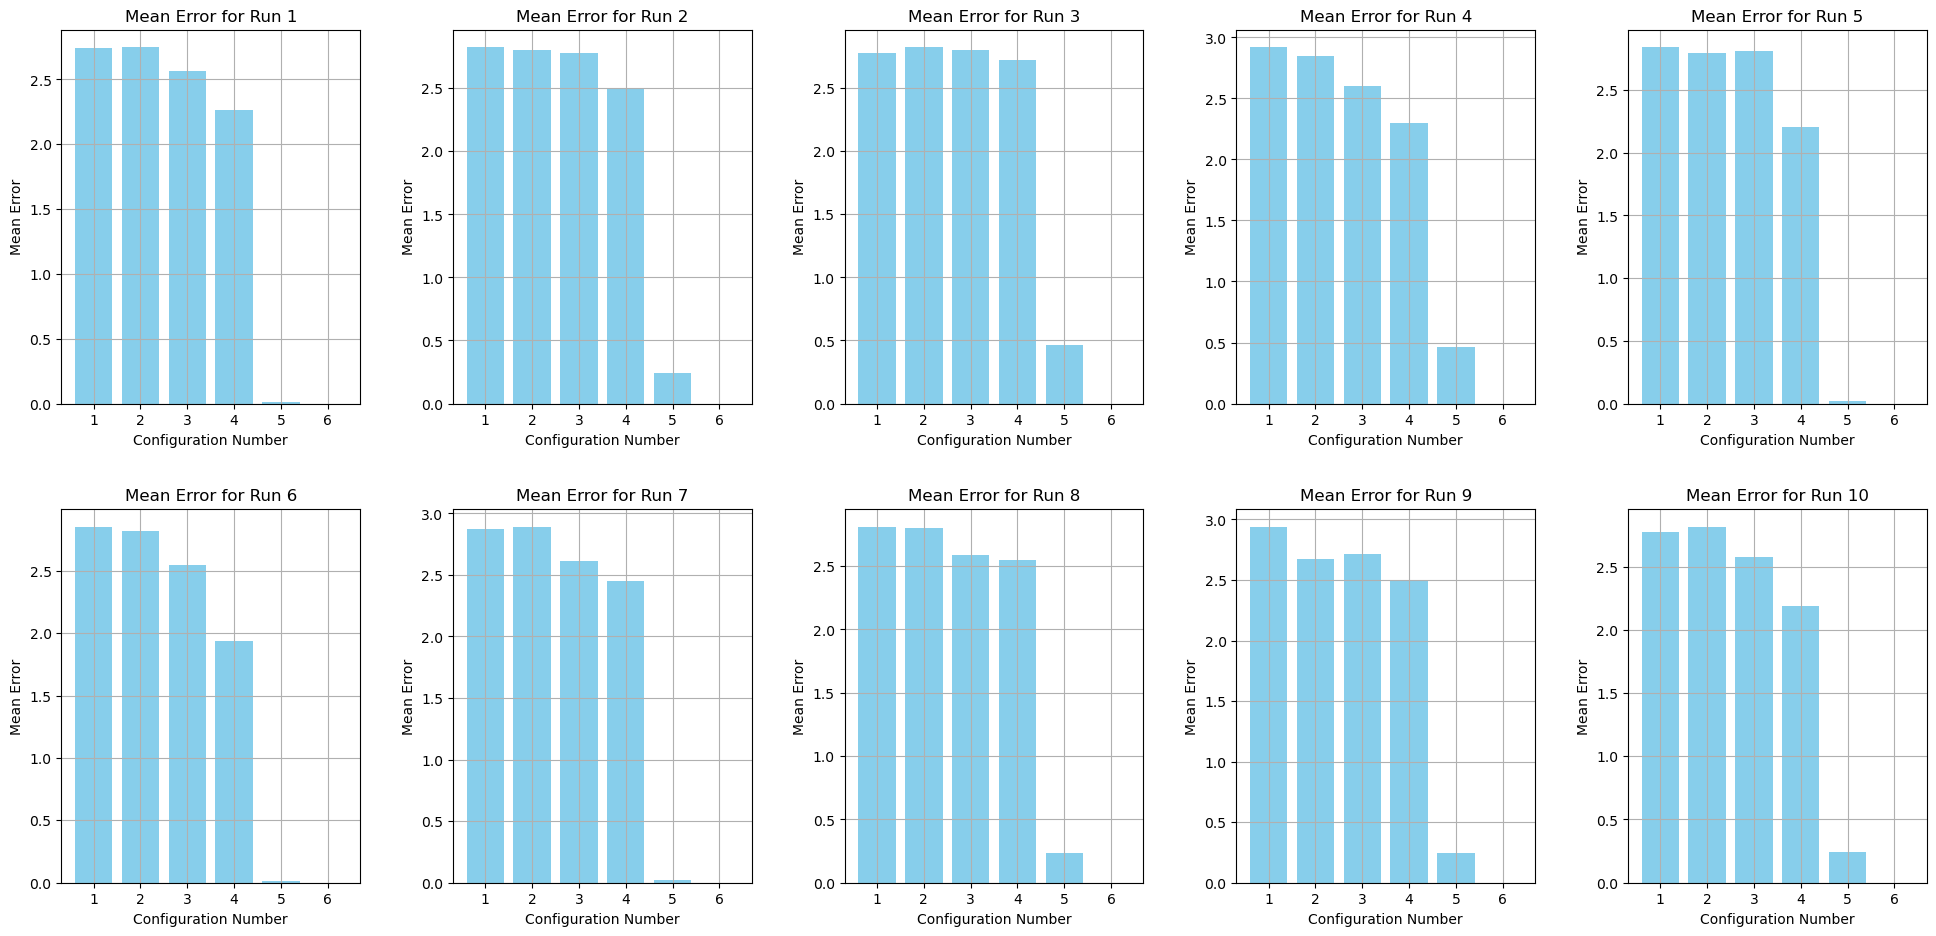

In [36]:
# Prepare data for plotting mean errors by each run across all configurations
mean_error_by_run = [[mean_errors[config][run] for config in range(num_configs)] for run in range(num_runs)]

# Plotting each run's data in a separate graph on a 2 by 5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust the overall size as needed
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for run in range(num_runs):
    axes[run].bar(range(1, num_configs + 1), mean_error_by_run[run], color='skyblue')
    axes[run].set_xlabel('Configuration Number')
    axes[run].set_ylabel('Mean Error')
    axes[run].set_title(f'Mean Error for Run {run + 1}')
    axes[run].set_xticks(range(1, num_configs + 1))
    axes[run].set_xticklabels([f'{i+1}' for i in range(num_configs)])
    axes[run].grid(True)

plt.tight_layout(pad=3.0)  # Adjust padding to prevent overlap
plt.show()